# Homework 5: FX Carry Strategy
##### Name: Anand Nakhate
##### Student ID: 12446907
##### Date: 14 February 2025


In [1]:
import os
import datetime
import quandl

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from scipy.stats import norm, skew, kurtosis, probplot

import quandl
from math import exp
from pandas.tseries.holiday import USFederalHolidayCalendar, AbstractHolidayCalendar
import math
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sns.set_context('talk')
sns.set_context("notebook", font_scale=0.8)
plt.rcParams.update({
    'axes.labelsize': 10,    # Axis labels
    'axes.titlesize': 12,    # Axes titles
    'xtick.labelsize': 8,    # X tick labels
    'ytick.labelsize': 8,    # Y tick labels
    'legend.fontsize': 9,    # Legend font size
    'figure.titlesize': 14   # Figure title size
})

# Abstract and Introduction

Emerging market (EM) currency carry strategies offer tantalizingly high yields but can be undermined by severe exchange‐rate and yield‐curve volatility. Motivated by the classic uncovered interest parity puzzle, we investigate a leveraged weekly rebalancing framework that borrows in low‐yielding GBP and invests in four EM currencies—Costa Rica, Pakistan, Turkey, and South Africa—where 5‐year swap rates significantly exceed the funding rate. We construct both single‐currency and portfolio strategies, including an equal‐weighted approach and a “max spread” rotation that invests solely in the highest‐yield differential each week. Our comprehensive simulation tracks not only the coupon carry but also MTM bond repricing, FX changes, and interest accrual on the borrowing leg.

To understand the real‐world viability and tail risks of these EM carry trades, we conduct a multifaceted analysis. We decompose weekly returns into FX, carry, and mark‐to‐market components, measure distributional properties (skew, kurtosis), and benchmark each currency’s performance against S&P 500, US T‐Bill, and broad bond indexes. Further, we apply Fama–French factor regressions to explore whether standard equity style factors explain any portion of these returns. Finally, we evaluate risk metrics such as VaR, expected shortfall, rolling Sharpe, and maximum drawdown, highlighting the interplay between sky‐high yields and catastrophic currency blowups. Our findings reveal that EM carry can deliver outsized returns (particularly in Pakistan) but is prone to extreme drawdowns (Turkey, South Africa), underscoring the central role of macroeconomic stability, geopolitical shifts, and global risk appetite.

# Data Acquisition and Exploratory Data Analysis

## Understanding the Data
1. FX Spot Rates (vs. USD):
- USDCRC (Costa Rican Colón)
  - Generally exhibits moderate volatility, influenced by tourism revenues, agricultural exports, and moderate capital inflows.
  - Over two decades, we see a gradual upward drift (USD buying more CRC), reflecting moderate inflation in Costa Rica and occasional interventions by the central bank.
- USDGBP (British Pound)
  - Historically more stable and liquid.
  - Volatility spikes around events like the 2008 Global Financial Crisis and the 2016 Brexit referendum.
  - Moves are heavily tied to Bank of England policy decisions, UK‑EU trade dynamics, and broad USD moves (e.g., Federal Reserve tightening cycles).
- USDPKR (Pakistani Rupee)
  - Showcases substantial depreciation against USD over time—jumps from ~50 to ~300 reflect persistent current account deficits, political uncertainty, and IMF program negotiations.
  - Extremely sensitive to foreign reserve levels, geopolitical developments, and domestic monetary policy shifts.
- USDTRY (Turkish Lira)
  - Displays some of the most dramatic currency swings, especially post‑2018.
  - Key drivers include unorthodox monetary policy, high inflation, geopolitical tensions, and repeated central bank interventions.
- USDZAR (South African Rand)
  - Historically influenced by commodity price cycles, domestic economic reforms, and risk‑on/risk‑off sentiment in global markets.
  - Large daily moves during times of global uncertainty (e.g., COVID onset in 2020) highlight South Africa’s EM vulnerability and relatively high yield environment.

2. UK Interest Rate Data
- Overnight Index Swap (OIS) Rate – IUDSOIA
  - Captures near‑term market expectations of Bank of England policy rates.
  - Long historical range (1997–2025) encompasses major monetary regimes: 1997 “independence” of the BoE, post‑2008 zero‑rate policy, and the 2021–2024 rate tightening response to renewed inflation.
- 5‑Year Swap Rate
  - Reflects medium‑term market sentiment on inflation, growth, and future policy.
  - Typically higher than the OIS due to longer duration, but the spread narrows or widens depending on the yield curve shape and systemic risk.

3. Emerging Market Swap Yield Curves (Turkey, Pakistan, Costa Rica, South Africa)
- Tenors: 0.5yr, 1yr, 5yr, 10yr.
- Data from ~2010 to 2025, capturing multiple crises and policy cycles in emerging markets.
- Used to model local fixed income “lending” rates in a hypothetical carry trade (5Y is crucial for the strategy’s coupon component).

### FX Spot Rates

In [2]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.environ["HOME"], "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key="SyATKMGuooiZSzbH97Bj", **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

In [3]:
currency_tickers = ["GBP", "TRY", "PKR","CRC","ZAR"]
currencies = fetch_quandl_table('EDI/CUR', code=currency_tickers)
currencies.head()

Skipping any possible download of EDI/CUR


,code,date,rate
0,CRC,2025-02-12,506.922792
1,CRC,2025-02-11,510.383840
2,CRC,2025-02-10,513.145836
3,CRC,2025-02-09,512.021667
4,CRC,2025-02-08,510.055179


In [4]:
currencies['date'] = pd.to_datetime(currencies['date'])
currencies_df = currencies.pivot(index='date', columns='code', values='rate')
currencies_df.columns = [f"USD{code}" for code in currencies_df.columns]
full_date_range = pd.date_range(start=currencies_df.index.min(), 
                                end=currencies_df.index.max(), freq='D')
currencies_df = currencies_df.reindex(full_date_range)
currencies_df.ffill(inplace=True)
currencies_df.index.name = 'date'
currencies_df.dropna(inplace=True)
currencies_df

,USDCRC,USDGBP,USDPKR,USDTRY,USDZAR
date,,,,,
2000-05-31,306.793507,0.668273,51.828051,0.616282,6.975660
2000-06-01,306.623794,0.669881,51.924634,0.612346,6.995069
2000-06-02,305.804383,0.665428,51.990035,0.617669,6.944569
2000-06-03,305.804383,0.666150,51.990035,0.617669,6.961750
2000-06-04,305.804383,0.666150,51.990035,0.617669,6.961750
...,...,...,...,...,...
2025-02-08,510.055179,0.806127,279.100000,35.883799,18.409280
2025-02-09,512.021667,0.806289,280.319122,35.883799,18.409300
2025-02-10,513.145836,0.806360,280.934663,36.023557,18.526500


In [5]:
print("FX Rates Summary:")
display(currencies_df.describe())

FX Rates Summary:


,USDCRC,USDGBP,USDPKR,USDTRY,USDZAR
count,9024.000000,9024.000000,9024.000000,9024.000000,9024.000000
mean,512.246000,0.670064,112.308915,5.480240,11.035046
std,79.918868,0.095425,63.925401,8.065937,3.999201
min,304.371986,0.474330,51.828051,0.608173,5.621797
25%,497.326126,0.608708,60.682139,1.451889,7.419825
50%,519.513339,0.659607,95.447037,1.806780,10.100179
75%,565.217935,0.759171,138.766184,5.459212,14.387659
max,693.655915,0.949311,308.187445,36.056300,19.763900


- Notable maximum rates illustrate extreme depreciations in PKR and TRY—indicative of inflation surges and external imbalances.
- Volatility (standard deviations) is highest for TRY and PKR, underscoring the risk of large drawdowns in an unhedged carry strategy.
- GBP volatility is comparatively lower, yet large policy shocks (e.g., Brexit) still create tail events in the distribution.

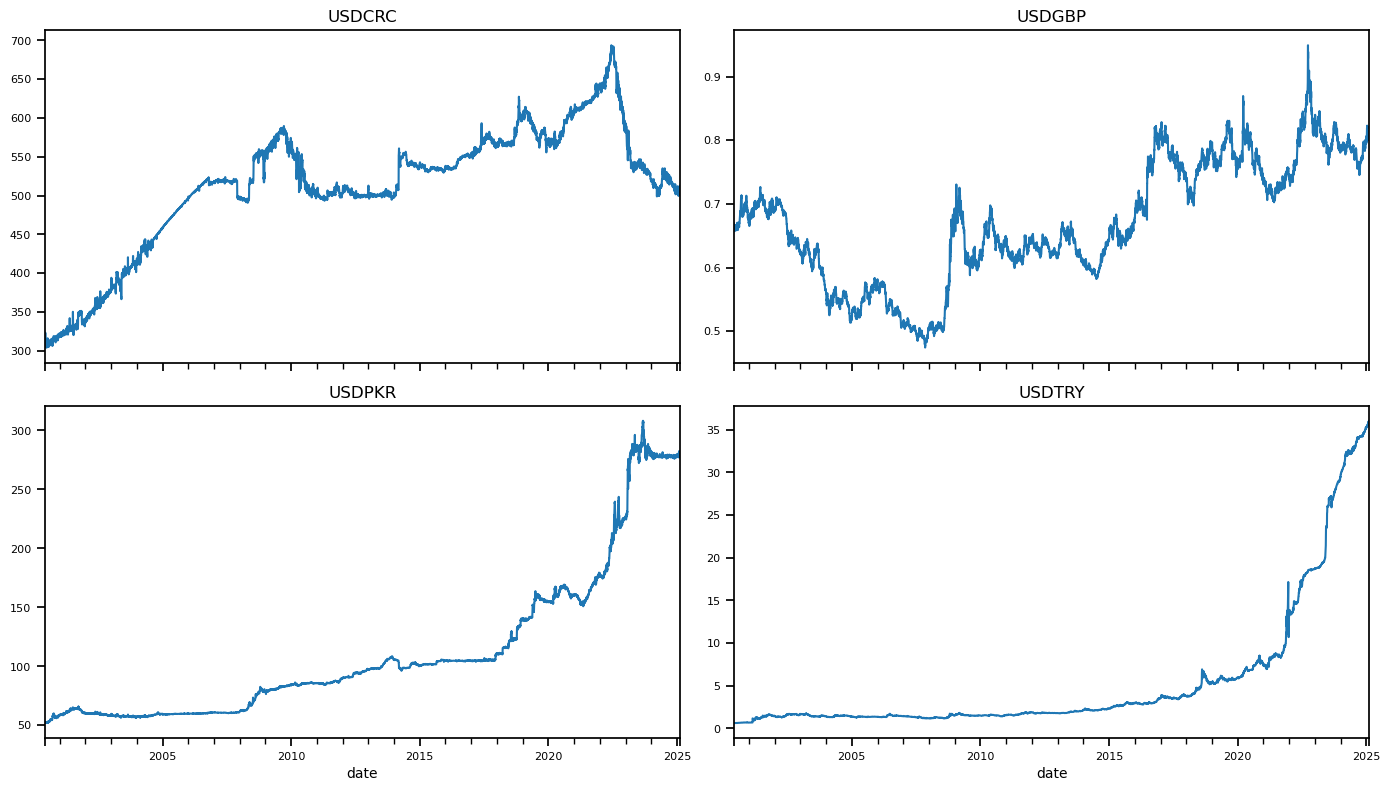

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
currencies_df['USDCRC'].plot(ax=axes[0, 0], title='USDCRC', legend=False)
currencies_df['USDGBP'].plot(ax=axes[0, 1], title='USDGBP', legend=False)
currencies_df['USDPKR'].plot(ax=axes[1, 0], title='USDPKR', legend=False)
currencies_df['USDTRY'].plot(ax=axes[1, 1], title='USDTRY', legend=False)
plt.tight_layout()
plt.show()

1. USDCRC
   - Gradual Increase to ~600+ Reflects a long‐term mild depreciation of the Costa Rican colón against the US dollar, partially offset by local monetary stability.
   - Occasional flattening phases coincide with policy measures to anchor the colón or periods of robust tourism and FDI inflows.
   - Minor Volatility Spikes Often correlate with global risk‐off episodes (e.g., 2008 financial crisis) when EM currencies face capital outflows.
2. USDGBP 
   - Notable Dip Around 2014–2015 - GBP strength amid early UK rate‐hike expectations and a post‐crisis recovery.
   - Major Spike in 2016 - Reflects Brexit referendum shock; GBP depreciated sharply as investors reassessed the UK’s economic future outside the EU.
   - Fluctuations After 2020 - Ongoing uncertainty with trade deals, pandemic impacts, and Bank of England policy changes.
3. USDPKR
   - Steep Climb Post‐2018 - Marked devaluations tied to Pakistan’s recurring balance‐of‐payments crises, IMF negotiations, and political instability.
   - Sharp Jumps in 2022–2023 - Reflect crises in external debt repayment, inflation surges, and concerns over central‐bank foreign reserves.
   - Overall Trend - Persistent PKR depreciation driven by high inflation, fiscal deficits, and periodic capital flight.
4. USDTRY
   - Accelerated Climb Post‐2018 - Turkish lira crises triggered by unconventional monetary policies, high inflation, and tensions with global markets.
   - Exponential Surge in 2021–2022 - Reflects a series of sharp rate cuts despite inflation, leading to heavy capital outflows and further lira weakening.
   - Political & Policy Shocks - Domestic governance shifts and external geopolitical pressures exacerbate the TRY’s vulnerability to speculation and volatility.

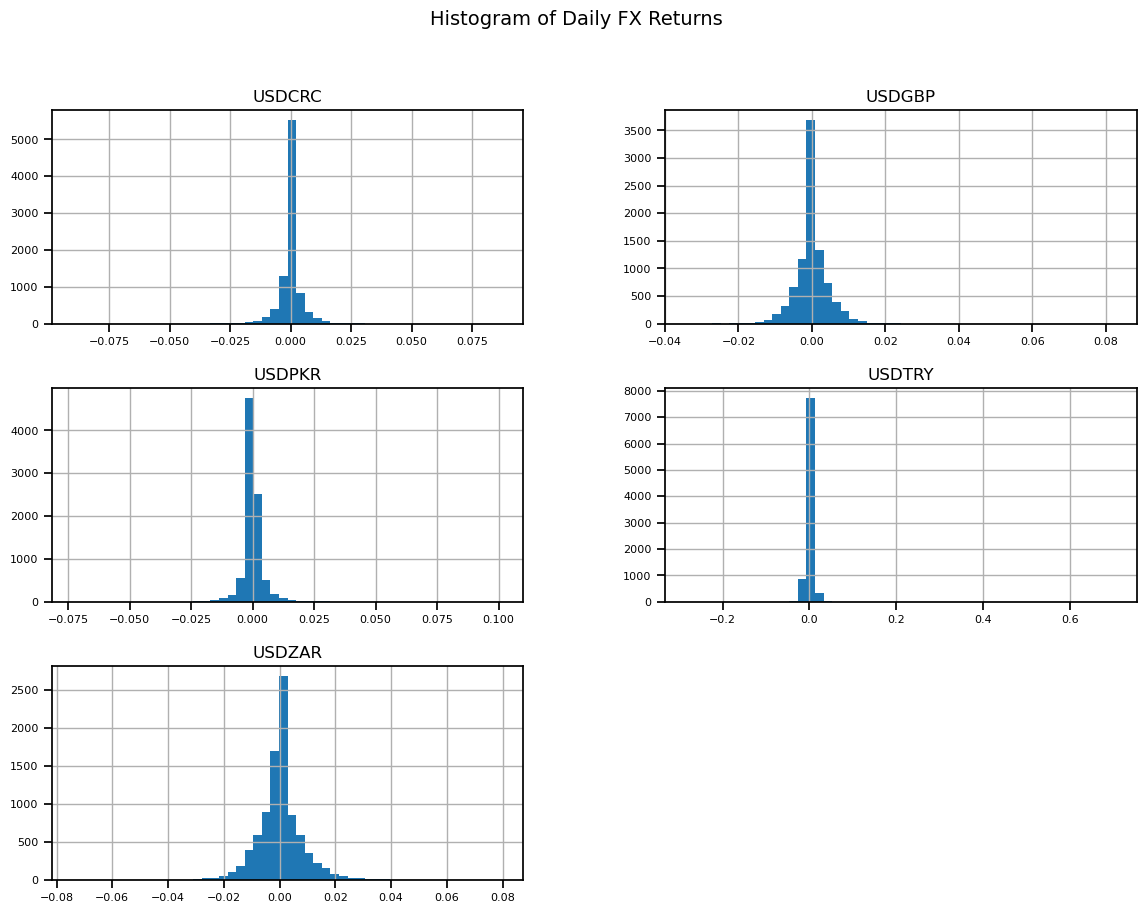

In [7]:
fx_returns = currencies_df.pct_change().dropna()
fx_returns.hist(bins=50, figsize=(14, 10))
plt.suptitle("Histogram of Daily FX Returns")
plt.show()

Histograms of Daily FX Returns (USDCRC, USDGBP, USDPKR, USDTRY, USDZAR)
 - All distributions peak around zero but exhibit skewness and leptokurtic tails, indicative of occasional extreme moves.
 - TRY’s histogram has a distinctly wider tail on the negative side (i.e., Lira depreciation events), consistent with macro/political shocks.
 - Carry trades on EM currencies face large negative tail risks.
 - Risk management (e.g., stop losses, options hedging) is pivotal to avoid catastrophic drawdowns.


In [8]:
fx_returns = np.log(currencies_df / currencies_df.shift(1))
display(fx_returns.describe())

,USDCRC,USDGBP,USDPKR,USDTRY,USDZAR
count,9023.000000,9023.000000,9023.000000,9023.000000,9023.000000
mean,0.000056,0.000020,0.000187,0.000451,0.000108
std,0.005497,0.004631,0.004762,0.010741,0.008096
min,-0.094107,-0.034779,-0.075836,-0.333035,-0.076927
25%,-0.000977,-0.001810,-0.000800,-0.001935,-0.003370
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.001063,0.001730,0.001042,0.002297,0.003190
max,0.083712,0.079326,0.096557,0.533468,0.076763


- Mean returns hover near zero, standard for exchange rates, but the distribution of returns is non‑normal with fat tails.
- Min and max log returns highlight episodes of rapid devaluations—e.g., TRY’s single‑day crashes (over 30% in some cases) linked to political events or abrupt monetary policy changes.

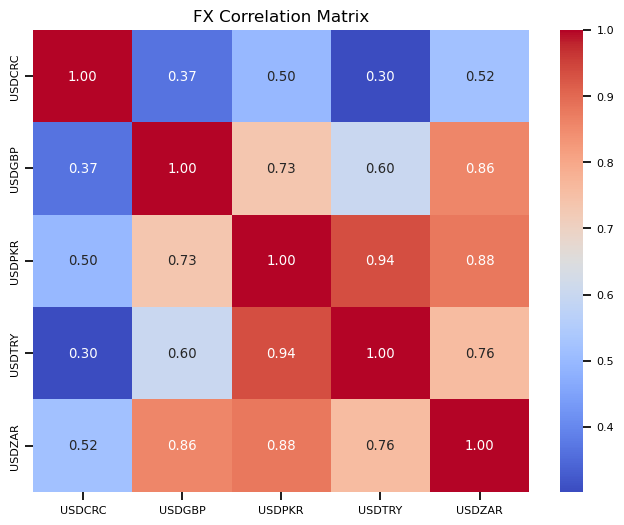

In [9]:
corr_fx = currencies_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_fx, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("FX Correlation Matrix")
plt.show()

- We can see that the correlations are pretty high.
- For instance, PKR–TRY is extremely high (0.94), suggesting that over long horizons, these EM currencies often depreciate in tandem versus USD, possibly reflecting broad EM risk sentiment.
- Spot-level movements might trend similarly, but daily returns can still diverge.
- Structural, persistent depreciation (vs. USD) is common in many EMs, driven by inflation differentials and repeated external account deficits.

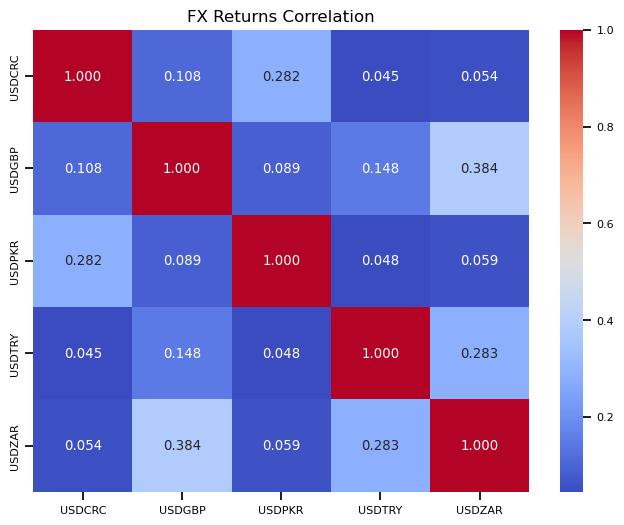

In [10]:
fx_corr = fx_returns.corr()
plt.figure(figsize=(8,6))
sns.heatmap(fx_corr, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("FX Returns Correlation")
plt.show()

- Low to Moderate Correlations
- Pairs like USDTRY–USDPKR show moderate correlation, reflecting shared EM vulnerabilities, but not perfectly synchronized due to unique domestic drivers.
- GBP is moderately correlated with ZAR, possibly reflecting global risk appetite rather than direct economic linkage.
- A diversified basket of EM currency positions can dampen short‑term volatility.
- However, during major risk‑off episodes, correlations can spike, undermining diversification benefits.

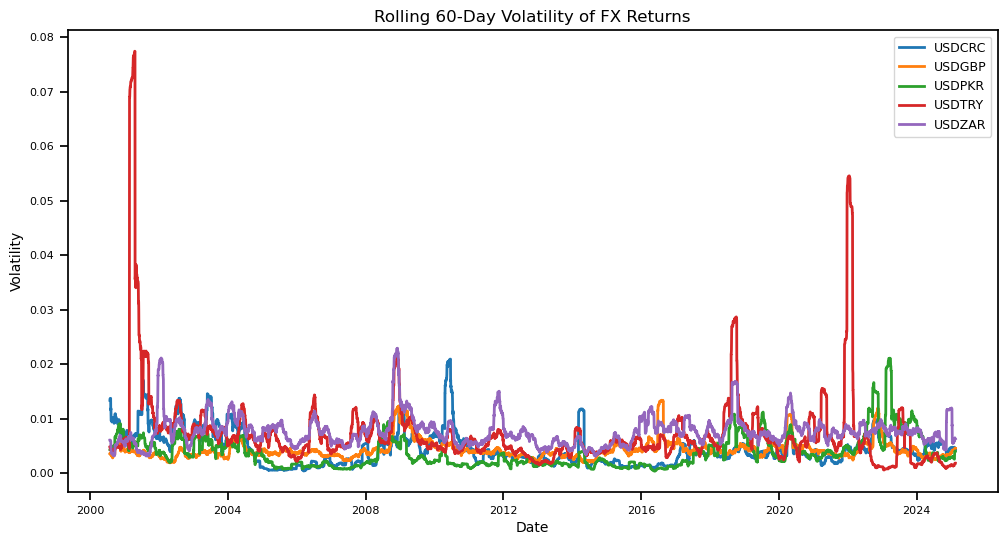

In [11]:
# Rolling volatility (60-day) for each FX rate
window = 60
fx_vol = fx_returns.rolling(window=window).std()
plt.figure(figsize=(12,6))
for col in fx_vol.columns:
    plt.plot(fx_vol.index, fx_vol[col], label=col, lw=2)
plt.title(f"Rolling {window}-Day Volatility of FX Returns")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

- For TRY, we see recurrent spikes in the early 2000s (Turkish banking crisis), 2018 (acute currency crisis), and around 2020–2023.
- For ZAR, we can see notable surges often track global commodity cycles and episodes of domestic unrest.
- For GBP, we see a milder baseline, with abrupt spikes in 2008 and post‑Brexit 2016.
- Each spike often corresponds to central bank policy surprises, elections, political turnover, or global crises (e.g., COVID).
- High volatility amplifies carry trade mark‑to‑market losses if the currency moves suddenly against a leveraged position.

### UK Interest Rate Data

In [12]:
# OIS Rate England
iudsoia = pd.read_csv("data/IUDSOIA.csv")
iudsoia.columns = ["Date", "IUDSOIA"]
iudsoia['Date'] = pd.to_datetime(iudsoia['Date'])
iudsoia.set_index("Date", inplace=True)
iudsoia

,IUDSOIA
Date,
2025-02-10,4.4540
2025-02-07,4.4540
2025-02-06,4.4544
2025-02-05,4.7045
2025-02-04,4.7049
...,...
1997-01-08,5.9600
1997-01-07,5.9400
1997-01-06,5.9000


In [13]:
print("IUDSOIA Summary:")
display(iudsoia.describe())

IUDSOIA Summary:


,IUDSOIA
count,7102.000000
mean,2.786502
std,2.429821
min,0.039400
25%,0.454800
50%,2.926900
75%,4.988375
max,8.606800


In [14]:
funding_5y_swap_rate = pd.read_csv("data/england_yields.csv")[['date', '5Y']]
funding_5y_swap_rate['date'] = pd.to_datetime(funding_5y_swap_rate['date'])
funding_5y_swap_rate.set_index('date', inplace=True)
funding_5y_swap_rate

,5Y
date,
2000-01-04,6.3171
2000-01-05,6.3786
2000-01-06,6.3921
2000-01-07,6.3387
2000-01-10,6.2749
...,...
2025-02-06,4.0430
2025-02-07,4.0302
2025-02-10,4.0411


In [15]:
print("UK 5Y Funding Swap Rates Summary:")
display(funding_5y_swap_rate.describe())

UK 5Y Funding Swap Rates Summary:


,5Y
count,6346.000000
mean,2.758860
std,1.852290
min,-0.142600
25%,0.974600
50%,2.661350
75%,4.517475
max,6.497400


- Minimum rates below 1% reflect the post‑2008 QE period.
- Recent climbs above 4%–5% confirm the global tightening cycle (2021–2024) in response to inflation.
- The difference between OIS and the 5Y swap rate can serve as a barometer of the market’s confidence in long‑term UK economic health.

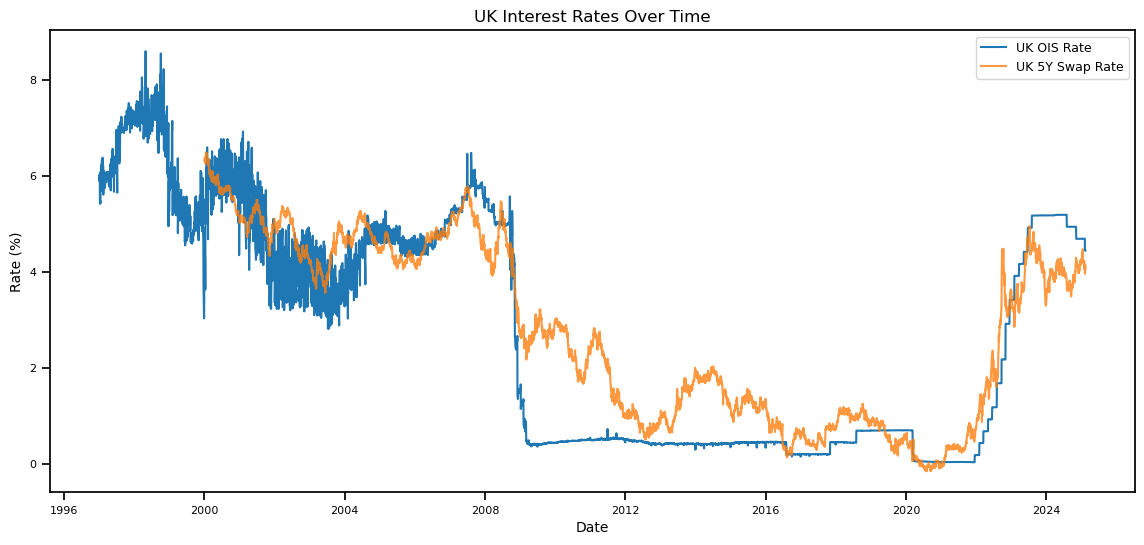

In [16]:
plt.figure(figsize=(14, 6))
plt.plot(iudsoia.index, iudsoia['IUDSOIA'], label="UK OIS Rate")
plt.plot(funding_5y_swap_rate.index, funding_5y_swap_rate['5Y'], label="UK 5Y Swap Rate", alpha=0.8)
plt.title("UK Interest Rates Over Time")
plt.xlabel("Date")
plt.ylabel("Rate (%)")
plt.legend()
plt.show()

- Interest rates peak rates near 6–8% in late 1990s–early 2000s; plunge to near zero post‑2009, then a resurgence near 4–5% by 2024–2025.
- 2008–2009: The Global Financial Crisis forced rates towards the lower bound.
- 2016: Post‑Brexit referendum uncertainty kept rates subdued but introduced volatility in longer maturities.
- 2021–2024: Global inflation pressures triggered the fastest rate hikes in decades, shifting the yield curve upwards.

### Emerging Market Swap Yield Curves/ Zero Curves (Turkey, Pakistan, Costa Rica, South Africa)

In [17]:
regions = ['Rep Turkey', 'Islamic Rep Pakistan', 'Rep Costa Rica', 'Rep South Africa']
swap_yield_data = pd.read_csv("data/InferredYieldCurves_2025-02-04.tab", delimiter='\t')
swap_yield_data.drop(columns=["Unnamed: 0"], inplace=True)
swap_yield_data = swap_yield_data[swap_yield_data['shortname'].isin(regions)]
swap_yield_data['date'] = pd.to_datetime(swap_yield_data['date'])
swap_yield_data

,shortname,tenor,date,yield
45130,Islamic Rep Pakistan,10Y,2010-01-04,0.148722
45131,Islamic Rep Pakistan,10Y,2010-01-05,0.147922
45132,Islamic Rep Pakistan,10Y,2010-01-06,0.148722
45133,Islamic Rep Pakistan,10Y,2010-01-07,0.144167
45134,Islamic Rep Pakistan,10Y,2010-01-08,0.143967
...,...,...,...,...
244381,Rep Turkey,6M,2025-01-29,0.052674
244382,Rep Turkey,6M,2025-01-30,0.052313
244383,Rep Turkey,6M,2025-01-31,0.052177
244384,Rep Turkey,6M,2025-02-03,0.052303


In [18]:
tenor_map = {
    "6M": 0.5,
    "1Y": 1.0,
    "5Y": 5.0,
    "10Y": 10.0
}
swap_yield_curves = {}

for region in regions:
    df_region = swap_yield_data[swap_yield_data['shortname'] == region].copy()
    pivoted = df_region.pivot_table(index='date', 
                                  columns='tenor', 
                                  values='yield')
    pivoted.rename(columns=tenor_map, inplace=True)
    pivoted.sort_index(inplace=True)
    pivoted = pivoted[[0.5, 1.0, 5.0, 10.0]]
    pivoted.dropna(subset=[5.0], inplace=True)
    pivoted.ffill(inplace=True)
    swap_yield_curves[region] = pivoted
swap_yield_curves.keys()

dict_keys(['Rep Turkey', 'Islamic Rep Pakistan', 'Rep Costa Rica', 'Rep South Africa'])

In [19]:
for region, swap_region_df in swap_yield_curves.items():
    print(f"Swap Yield Rates for {region}")
    display(swap_yield_curves[region].head())

Swap Yield Rates for Rep Turkey


tenor,0.5,1.0,5.0,10.0
date,,,,
2010-01-04,0.010601,0.016556,0.050620,0.065051
2010-01-05,0.010034,0.015585,0.049004,0.063484
2010-01-06,0.009991,0.015204,0.049329,0.064466
2010-01-07,0.010218,0.015400,0.049319,0.064495
2010-01-08,0.009627,0.015287,0.048692,0.063942


Swap Yield Rates for Islamic Rep Pakistan


tenor,0.5,1.0,5.0,10.0
date,,,,
2010-01-04,0.116467,0.0815,0.136500,0.148722
2010-01-05,0.116367,0.0811,0.135600,0.147922
2010-01-06,0.116167,0.0810,0.136000,0.148722
2010-01-07,0.075267,0.0810,0.136200,0.144167
2010-01-08,0.075167,0.0807,0.132811,0.143967


Swap Yield Rates for Rep Costa Rica


tenor,0.5,1.0,5.0,10.0
date,,,,
2010-01-04,0.011485,0.012753,0.045461,0.060319
2010-01-05,0.007155,0.012151,0.044628,0.060947
2010-01-06,0.006760,0.011969,0.044834,0.059599
2010-01-07,0.006860,0.011799,0.044247,0.058956
2010-01-08,0.006565,0.015362,0.043650,0.058759


Swap Yield Rates for Rep South Africa


tenor,0.5,1.0,5.0,10.0
date,,,,
2010-01-04,0.009400,0.013542,0.045298,0.059957
2010-01-05,0.008233,0.012789,0.043590,0.058291
2010-01-06,0.008736,0.012868,0.044305,0.059385
2010-01-07,0.008222,0.012381,0.043972,0.058993
2010-01-08,0.007713,0.011804,0.043319,0.058507


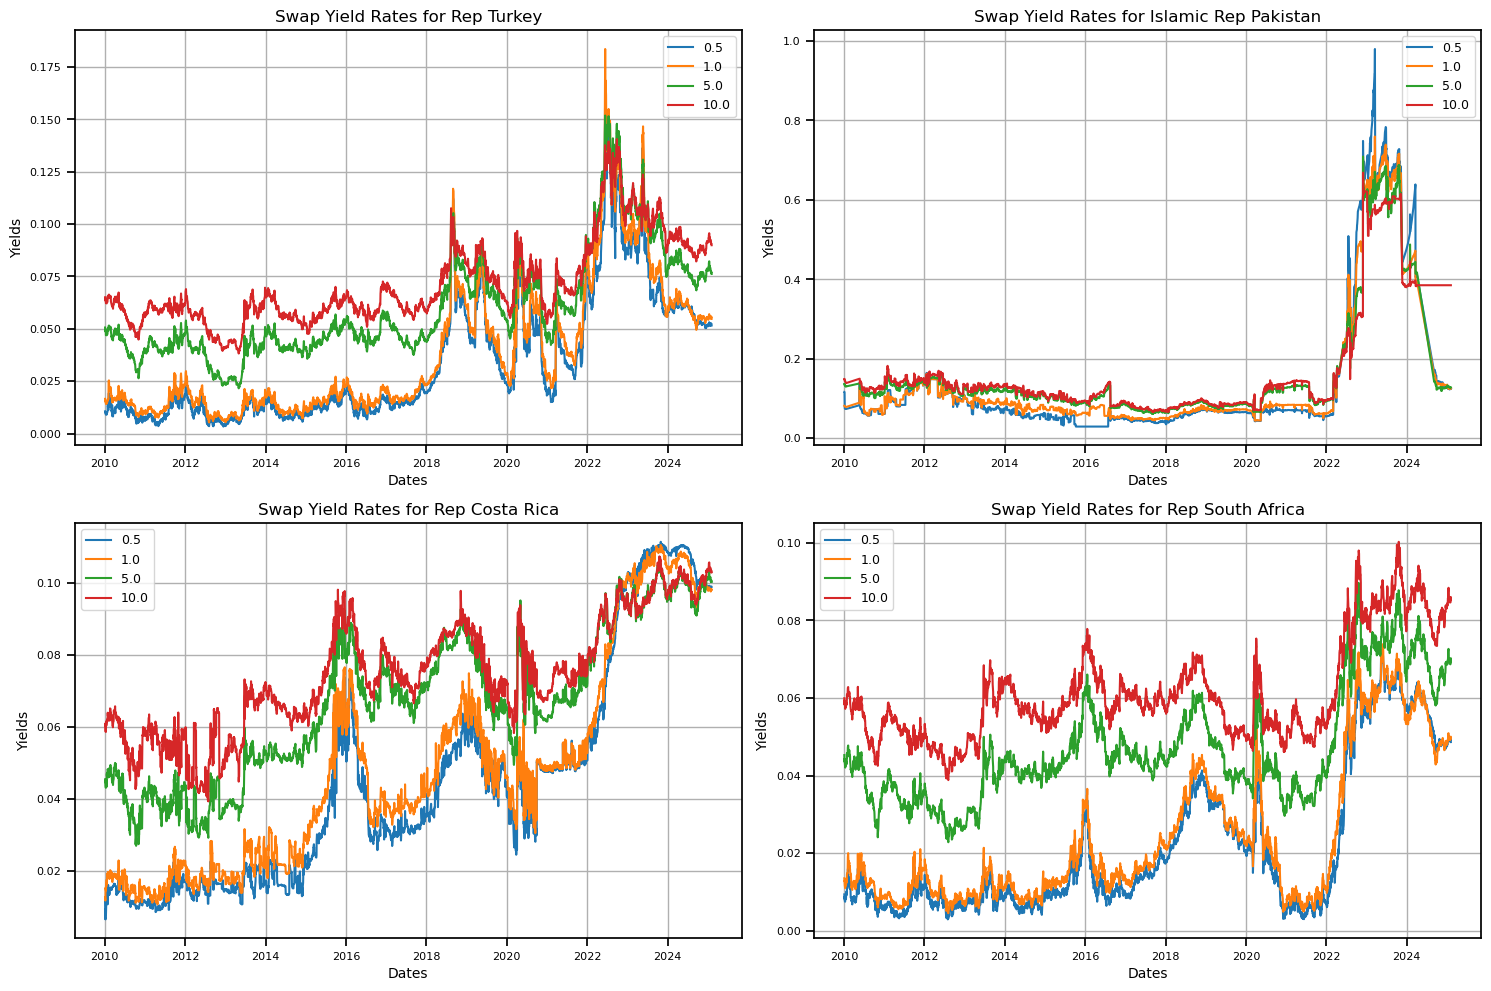

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()  
for ax, (region, df) in zip(axes, swap_yield_curves.items()):
    # Plot each tenor's yield curve
    for tenor in df.columns:
        ax.plot(df.index, df[tenor], label=tenor)
    
    ax.set_title(f"Swap Yield Rates for {region}")
    ax.set_xlabel("Dates")
    ax.set_ylabel("Yields")
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()

- Turkey
  - 0.5yr & 1yr soared above 15–20% in some episodes, reflective of emergency rate hikes to combat inflation.
  - The 5yr & 10yr tenors also rose sharply around 2021–2022, illustrating major investor wariness of longer‑term inflation.
- Pakistan
  - Generally stable yields pre‑2020, then a sharp escalation as the rupee devalued and the government engaged in IMF negotiations.
- Costa Rica
  - More moderate yield levels, with cyclical fluctuations tied to changes in local monetary policy and external funding conditions.
  - The 5yr yield typically trades in a 3–7% range, albeit with occasional spikes near 10%.
- South Africa
  - Yields heavily influenced by commodity cycles and investor sentiment.
  - Surges near 10% in 2020–2022, concurrent with credit rating concerns and COVID disruptions.

#### Zero Curves
##### Understanding Swap/ Yield Curve and Zero Curve
- In Fixed‑income valuation, one of the essential tasks is to convert swap rate quotes, which reflect fixed vs. floating payment exchanges at discrete maturities, into a continuous or piecewise set of discount factors (DFs).
- These discount factors allow us to price all future cash flows at any time point, offering a consistent framework for marking positions to market, analyzing interest rate sensitivities, and constructing hedges.
- They determine the fair value of swaps, bonds, and other interest rate derivatives.
- They help desks manage the curve risk and carry strategy performance.
- They facilitate robust risk management by ensuring trades are fairly priced against the “true” yield curve implied by market quotes.

##### Construction:(Bootstrapping the Curve)
- The bootstrapping transforms swap yields at discrete maturities into a detailed zero‑coupon discount curve on a quarterly grid.
- It leverages root-finding (with bracket expansion), log-linear interpolation, and robust iteration over each date to ensure reliability and consistency.
- Bootstrapping is the heart of getting zero rate from the spot rate: it methodically solves for discount factors at key maturities (0.25, 0.5, 1.0, 5.0, and 10.0 years) so that the present value of a fixed‑for‑floating swap at each maturity is 1 (i.e., par swap)
- Since we are working with bonds that pay quarterly, to get the zero rate for 3m, we need the spot rate for 3m. Since the data is not available readily, we assume that the short end of the curve is linear (as it generally is considered to be becasue of the duration and convexity effect)
- After solving the bootstrappingfor each anchor point, we log‑linearly interpolate the discount factors for intermediate quarter points.

In [21]:
# Building Zero Rate and Zero Discount Factor from Swap Curve

# Helper: Expand bracket until we find a sign change or exceed max attempts
def find_bracket_expanding(f, x_lo, x_hi, max_expansions=10, expansion_factor=2.0):
    f_lo = f(x_lo)
    f_hi = f(x_hi)
    expansions = 0
    while np.sign(f_lo) == np.sign(f_hi) and expansions < max_expansions:
        x_hi *= expansion_factor
        f_hi = f(x_hi)
        expansions += 1
    if np.sign(f_lo) == np.sign(f_hi):
        raise ValueError("Could not find valid bracket for root finding after expansion.")
    return x_lo, x_hi

# Extrapolate the 3-month yield from 6m & 1y
def extrapolate_short_end(df):
    df = df.copy()
    df[0.25] = 1.5 * df[0.5] - 0.5 * df[1.0]
    return df

# Bootstrapping for a single row of yields
def bootstrap_discount_factors_for_row(yields):
    dfs = {}    
    
    # DF(0.25)
    c_025 = yields[0.25] / 4.0
    dfs[0.25] = 1.0 / (1.0 + c_025)
    
    # DF(0.5)
    c_05 = yields[0.5] / 4.0
    dfs[0.5] = (1.0 - c_05 * dfs[0.25]) / (1.0 + c_05)
    
    # DF(1.0): coupons at 0.25, 0.5, 0.75, 1.0
    c_1 = yields[1.0] / 4.0
    def eq_DF1(DF1):
        weight = (0.75 - 0.5) / (1.0 - 0.5)
        DF_075 = np.exp( (1-weight)*np.log(dfs[0.5]) + weight*np.log(DF1) )
        return c_1 * (dfs[0.25] + dfs[0.5] + DF_075) + (1 + c_1)*DF1 - 1.0
    # Use a wide initial bracket [0, 2]
    f = lambda x: eq_DF1(x)
    x_lo, x_hi = 1e-12, 2.0
    x_lo, x_hi = find_bracket_expanding(f, x_lo, x_hi)
    sol_1 = optimize.root_scalar(f, bracket=[x_lo, x_hi], method='bisect')
    dfs[1.0] = sol_1.root
    
    # DF(0.75)
    weight = (0.75 - 0.5) / (1.0 - 0.5)
    dfs[0.75] = np.exp( (1-weight)*np.log(dfs[0.5]) + weight*np.log(dfs[1.0]) )
    
    # DF(5.0): coupons from 1.25, 1.5, 1.75, ... up to 5.0
    c_5 = yields[5.0] / 4.0
    known_coupons = c_5 * (dfs[0.25] + dfs[0.5] + dfs[0.75] + dfs[1.0])
    
    def eq_DF5(DF5):
        s = 0.0
        times = np.arange(1.25, 5.0, 0.25)
        for t in times:
            weight = (t - 1.0) / (5.0 - 1.0)
            DF_interp = np.exp( (1-weight)*np.log(dfs[1.0]) + weight*np.log(DF5) )
            s += c_5 * DF_interp
        return known_coupons + s + (1 + c_5)*DF5 - 1.0
    
    f = lambda x: eq_DF5(x)
    x_lo, x_hi = 1e-12, 2.0
    x_lo, x_hi = find_bracket_expanding(f, x_lo, x_hi)
    sol_5 = optimize.root_scalar(f, bracket=[x_lo, x_hi], method='bisect')
    dfs[5.0] = sol_5.root    
    times_1_5 = np.arange(1.25, 5.0, 0.25)
    for t in times_1_5:
        weight = (t - 1.0)/(5.0 - 1.0)
        dfs[t] = np.exp( (1-weight)*np.log(dfs[1.0]) + weight*np.log(dfs[5.0]) )
    
    # DF(10.0): coupons from 5.25, 5.5, ... up to 10.0
    c_10 = yields[10.0] / 4.0
    known_sum_5 = c_10 * sum( dfs[t] for t in dfs if t <= 5.0 )
    
    def eq_DF10(DF10):
        s = 0.0
        times = np.arange(5.25, 10.0, 0.25)
        for t in times:
            weight = (t - 5.0) / (10.0 - 5.0)
            DF_interp = np.exp( (1-weight)*np.log(dfs[5.0]) + weight*np.log(DF10) )
            s += c_10 * DF_interp
        return known_sum_5 + s + (1 + c_10)*DF10 - 1.0
    
    f = lambda x: eq_DF10(x)
    x_lo, x_hi = 1e-12, 2.0
    x_lo, x_hi = find_bracket_expanding(f, x_lo, x_hi)
    sol_10 = optimize.root_scalar(f, bracket=[x_lo, x_hi], method='bisect')
    dfs[10.0] = sol_10.root    
    times_5_10 = np.arange(5.25, 10.0, 0.25)
    for t in times_5_10:
        weight = (t - 5.0)/(10.0 - 5.0)
        dfs[t] = np.exp( (1-weight)*np.log(dfs[5.0]) + weight*np.log(dfs[10.0]) )
    return dfs

def build_full_quarterly_curve(boot_dfs, max_t=10.0):
    times_known = np.array(sorted(boot_dfs.keys()))
    dfs_known = np.array([boot_dfs[t] for t in times_known])
    t_grid = np.arange(0.25, max_t + 0.25, 0.25)    
    log_dfs_known = np.log(dfs_known)
    log_dfs_interp = np.interp(t_grid, times_known, log_dfs_known)
    dfs_interp = np.exp(log_dfs_interp)
    return pd.Series(dfs_interp, index=t_grid)

def process_yield_curve_df(df):
    results = {}
    for date, row in df.iterrows():
        y_6m = row[0.5]
        y_1y = row[1.0]        
        y_3m = 1.5 * y_6m - 0.5 * y_1y
        yields_dict = {
            0.25: y_3m,
            0.5 : y_6m,
            1.0 : y_1y,
            5.0 : row[5.0],
            10.0: row[10.0]
        }
        try:
            boot_dfs = bootstrap_discount_factors_for_row(yields_dict)
        except ValueError as e:
            continue
        dfs_series = build_full_quarterly_curve(boot_dfs, max_t=10.0)
        results[date] = dfs_series
    return pd.DataFrame(results).T

def process_all_yield_curves(swap_yield_curves):
    result = {}
    for region, df in swap_yield_curves.items():
        df_dfs = process_yield_curve_df(df)
        result[region] = df_dfs
    return result


In [22]:
discount_factors_dict = process_all_yield_curves(swap_yield_curves)
for region, discount_df in discount_factors_dict.items():
    print(f"Discount Factors for {region}")
    display(discount_df)

Discount Factors for Rep Turkey


,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,...,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75,10.00
2010-01-04,0.998098,0.994718,0.989137,0.983586,0.968968,0.954567,0.940380,0.926404,0.912636,0.899072,...,0.613063,0.600205,0.587617,0.575292,0.563227,0.551414,0.539849,0.528527,0.517442,0.506590
2010-01-05,0.998189,0.995000,0.989757,0.984542,0.970349,0.956361,0.942575,0.928987,0.915596,0.902397,...,0.620914,0.608140,0.595629,0.583375,0.571374,0.559619,0.548106,0.536830,0.525786,0.514969
2010-01-06,0.998157,0.995022,0.989957,0.984918,0.970592,0.956474,0.942562,0.928853,0.915342,0.902028,...,0.616439,0.603456,0.590745,0.578302,0.566122,0.554198,0.542525,0.531097,0.519911,0.508960
2010-01-07,0.998097,0.994909,0.989804,0.984725,0.970419,0.956320,0.942426,0.928734,0.915241,0.901944,...,0.616348,0.603354,0.590633,0.578181,0.565991,0.554059,0.542377,0.530943,0.519749,0.508791
2010-01-08,0.998304,0.995202,0.990004,0.984834,0.970714,0.956797,0.943079,0.929559,0.916231,0.903095,...,0.619188,0.606210,0.593504,0.581064,0.568885,0.556961,0.545287,0.533858,0.522668,0.511713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-29,0.987407,0.974169,0.959914,0.945867,0.926321,0.907180,0.888435,0.870076,0.852097,0.834490,...,0.496809,0.483012,0.469598,0.456556,0.443877,0.431549,0.419565,0.407912,0.396584,0.385570
2025-01-30,0.987472,0.974343,0.960261,0.946383,0.927140,0.908289,0.889821,0.871729,0.854004,0.836640,...,0.501969,0.488222,0.474853,0.461849,0.449201,0.436900,0.424935,0.413299,0.401981,0.390972
2025-01-31,0.987507,0.974408,0.960347,0.946489,0.927215,0.908334,0.889838,0.871718,0.853967,0.836578,...,0.501454,0.487693,0.474310,0.461294,0.448635,0.436324,0.424351,0.412706,0.401381,0.390366
2025-02-03,0.987502,0.974347,0.960159,0.946178,0.926812,0.907842,0.889260,0.871059,0.853231,0.835767,...,0.500911,0.487207,0.473879,0.460915,0.448306,0.436041,0.424113,0.412510,0.401225,0.390249


Discount Factors for Islamic Rep Pakistan


,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,...,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75,10.00
2010-01-04,0.967598,0.944331,0.933711,0.923210,0.888639,0.855362,0.823332,0.792501,0.762824,0.734259,...,0.312279,0.299127,0.286529,0.274462,0.262903,0.251830,0.241224,0.231065,0.221334,0.212012
2010-01-05,0.967586,0.944378,0.933918,0.923574,0.889229,0.856160,0.824322,0.793667,0.764152,0.735735,...,0.314325,0.301138,0.288503,0.276399,0.264802,0.253692,0.243049,0.232851,0.223082,0.213722
2010-01-06,0.967644,0.944469,0.934008,0.923662,0.889186,0.855997,0.824046,0.793288,0.763679,0.735174,...,0.312121,0.298894,0.286228,0.274098,0.262483,0.251359,0.240707,0.230507,0.220738,0.211384
2010-01-07,0.982222,0.963390,0.942887,0.922821,0.888266,0.855004,0.822989,0.792172,0.762509,0.733957,...,0.324339,0.311763,0.299674,0.288054,0.276884,0.266148,0.255828,0.245908,0.236373,0.227208
2010-01-08,0.982222,0.963438,0.943052,0.923097,0.889523,0.857171,0.825996,0.795954,0.767005,0.739109,...,0.324434,0.311348,0.298790,0.286738,0.275172,0.264073,0.253422,0.243200,0.233391,0.223977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-26,0.905714,0.823491,0.753309,0.689109,0.622290,0.561950,0.507460,0.458255,0.413820,0.373694,...,0.074986,0.071094,0.067405,0.063907,0.060590,0.057446,0.054465,0.051638,0.048958,0.046417
2024-03-27,0.905583,0.823311,0.753174,0.689012,0.622329,0.562100,0.507700,0.458565,0.414185,0.374100,...,0.075422,0.071525,0.067830,0.064325,0.061002,0.057850,0.054861,0.052027,0.049339,0.046790
2024-03-28,0.905450,0.823059,0.752807,0.688551,0.621859,0.561626,0.507228,0.458098,0.413727,0.373654,...,0.075642,0.071767,0.068089,0.064601,0.061291,0.058151,0.055171,0.052344,0.049662,0.047118
2024-04-01,0.905037,0.822371,0.751984,0.687621,0.620670,0.560238,0.505690,0.456453,0.412010,0.371895,...,0.074957,0.071125,0.067488,0.064037,0.060763,0.057656,0.054709,0.051911,0.049257,0.046739


Discount Factors for Rep Costa Rica


,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,...,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75,10.00
2010-01-04,0.997295,0.994282,0.990806,0.987343,0.974031,0.960899,0.947944,0.935163,0.922555,0.910116,...,0.637274,0.624619,0.612216,0.600058,0.588143,0.576464,0.565016,0.553797,0.542799,0.532021
2010-01-05,0.998837,0.996431,0.992168,0.987923,0.974822,0.961894,0.949138,0.936550,0.924130,0.911874,...,0.635174,0.622139,0.609371,0.596865,0.584616,0.572618,0.560866,0.549356,0.538082,0.527039
2010-01-06,0.998962,0.996628,0.992356,0.988102,0.974921,0.961916,0.949084,0.936423,0.923932,0.911606,...,0.640827,0.628244,0.615907,0.603813,0.591956,0.580332,0.568936,0.557764,0.546811,0.536074
2010-01-07,0.998904,0.996578,0.992416,0.988272,0.975261,0.962422,0.949752,0.937248,0.924910,0.912733,...,0.644139,0.631614,0.619332,0.607289,0.595480,0.583901,0.572547,0.561413,0.550496,0.539792
2010-01-08,0.999459,0.996724,0.990717,0.984747,0.972209,0.959830,0.947608,0.935543,0.923631,0.911870,...,0.645839,0.633234,0.620876,0.608759,0.596878,0.585229,0.573808,0.562609,0.551629,0.540863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-29,0.975762,0.952324,0.929766,0.907742,0.885278,0.863370,0.842004,0.821167,0.800845,0.781027,...,0.454036,0.442148,0.430571,0.419297,0.408319,0.397628,0.387217,0.377079,0.367206,0.357591
2025-01-30,0.975750,0.952324,0.929811,0.907831,0.885468,0.863657,0.842383,0.821633,0.801394,0.781654,...,0.455063,0.443160,0.431568,0.420279,0.409285,0.398579,0.388153,0.378000,0.368113,0.358484
2025-01-31,0.975727,0.952279,0.929746,0.907746,0.885251,0.863314,0.841920,0.821057,0.800711,0.780868,...,0.452985,0.441054,0.429436,0.418125,0.407112,0.396389,0.385948,0.375783,0.365885,0.356248
2025-02-03,0.975753,0.952260,0.929580,0.907440,0.885000,0.863114,0.841770,0.820953,0.800652,0.780852,...,0.454270,0.442398,0.430837,0.419577,0.408612,0.397934,0.387534,0.377407,0.367544,0.357939


Discount Factors for Rep South Africa


,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,...,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75,10.00
2010-01-04,0.998171,0.995315,0.990926,0.986557,0.973358,0.960336,0.947488,0.934812,0.922306,0.909967,...,0.639032,0.626448,0.614112,0.602019,0.590165,0.578544,0.567151,0.555983,0.545035,0.534302
2010-01-05,0.998514,0.995895,0.991586,0.987296,0.974572,0.962011,0.949613,0.937374,0.925293,0.913368,...,0.647737,0.635261,0.623026,0.611026,0.599257,0.587715,0.576395,0.565293,0.554405,0.543727
2010-01-06,0.998335,0.995645,0.991423,0.987220,0.974278,0.961506,0.948902,0.936462,0.924186,0.912071,...,0.642333,0.629691,0.617298,0.605149,0.593239,0.581563,0.570117,0.558897,0.547897,0.537114
2010-01-07,0.998467,0.995901,0.991792,0.987700,0.974823,0.962114,0.949571,0.937191,0.924973,0.912914,...,0.644290,0.631689,0.619335,0.607222,0.595346,0.583703,0.572287,0.561094,0.550120,0.539361
2010-01-08,0.998585,0.996154,0.992204,0.988270,0.975551,0.962996,0.950603,0.938369,0.926293,0.914372,...,0.646953,0.634348,0.621988,0.609870,0.597987,0.586336,0.574912,0.563711,0.552728,0.541959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-29,0.987851,0.975792,0.963794,0.951943,0.934370,0.917121,0.900190,0.883572,0.867261,0.851251,...,0.524167,0.510131,0.496471,0.483177,0.470239,0.457647,0.445393,0.433467,0.421859,0.410563
2025-01-30,0.987869,0.975852,0.963929,0.952153,0.934757,0.917678,0.900912,0.884451,0.868292,0.852428,...,0.526503,0.512457,0.498786,0.485480,0.472528,0.459923,0.447653,0.435711,0.424087,0.412774
2025-01-31,0.987824,0.975754,0.963770,0.951934,0.934365,0.917121,0.900195,0.883581,0.867274,0.851268,...,0.523278,0.509185,0.495470,0.482126,0.469140,0.456505,0.444209,0.432245,0.420603,0.409275
2025-02-03,0.987952,0.975844,0.963580,0.951470,0.933657,0.916178,0.899026,0.882195,0.865679,0.849473,...,0.520369,0.506318,0.492647,0.479345,0.466403,0.453809,0.441556,0.429634,0.418033,0.406746


1. Emerging Market Vs Developed Market
-  Emerging Market currencies exhibit significantly higher yields but also greater FX volatility and political risk.
- Developed Market rates (like UK OIS) show cyclical variation, but rarely approach EM levels of yield or volatility.
- Political regime changes, central bank independence (or lack thereof), and social unrest directly affect yield curves and FX rates in EMs.
- For instance, elections in Turkey or Pakistan often coincide with dramatic yield and currency shifts.
   
2. Policy Spillovers
- Federal Reserve rate decisions and global liquidity conditions (e.g., QE or QT) can trigger broad EM currency swings, influencing both spot rates and local bond yields.
- As rates rise in the US/UK, the cost of funding an EM carry strategy also rises, reducing net spreads and increasing volatility.

3. Carry Trade Performance
- High yields in EM markets provide attractive nominal returns, but downside deviations can be severe if the local currency weakens sharply against USD.
- Correlation patterns suggest partial diversification across PKR, TRY, CRC, and ZAR, but extreme events (risk‑off) can lead to synchronous selloffs.

4. Risk
- The data underscores the necessity of hedging tail events—particularly in EM currencies prone to devaluations (TRY, PKR).
- Short‑tenor yield changes (like in Turkey or Pakistan) can be abrupt, making robust liquidity management essential to avoid margin squeezes.

# Methodology

#### Trading Logic: Borrowing and Lending

1. Entry/ Exit:
- We adopt a weekly rebalancing framework,
- Entering trades on Wednesdays (or the next business day)
- Exiting on Tuesdays (or the preceding business day if Tuesday is a holiday).

2. Funding Currency & Borrowing
- We borrow in GBP (chosen for its historically lower interest rate environment) at an annual, continuously compounded OIS rate plus a fixed 50 bps spread.
- The nominal notional is \\$10 MM each week, of which 80% (\\$8 MM) is borrowed and 20% (\\$2 MM) is our equity.
- Emerging‐Market Investment: We convert the total \\$10MM into the emerging‐market (EM) currency at the entry day’s USD/EM rate, then purchase a par bond with a 5‐year maturity.
- The coupon equals the local 5Y swap rate (annual CC), ensuring the bond is priced at par on entry.
- Entry Criterion: We only initiate a position if the local 5Y swap rate exceeds the funding 5yr swap rate + 50bps, both in annual CC terms:
  - SwapRate 5y,local−(OIS GBP + 0.50%)>0.
  - If this condition fails, we remain out of the market for that EM currency for that week.
 
#### Mark‐to‐Market and Exit

1. Bond Valuation
- After roughly one week (Wednesday to Tuesday), the local par bond is repriced using the Nelson–Siegel spot curve from the exit day.
- We consider a decremented maturity of 5 years− 365/ daysHeld. 
- Coupons are discounted at the local spot rates for each future coupon date, and principal is discounted to the new present.
- A small accrued coupon is added for the partial holding period.

2. FX Conversions
- The bond proceeds (in local currency) are converted back into USD using the exit day EM→USD rate.
- Simultaneously, we repay the GBP principal + interest in GBP. We convert that repayment from GBP→USD at the exit day’s GBP→USD rate.
- The difference between the bond proceeds in USD and the repayment in USD constitutes the P&L.

3. Cash‐Flow Representation
- Let Notional=$10MM, Borrowed_USD=0.8×Notional.
- Borrowed GBP =Borrowed_USD×(USDGBP_entry).
- Final repayment in GBP includes continuous interest accrued: Repay GBP = Borrowed GBP × e (OIS GBP+0.50%)× 365/days old
- Conversion back to USD: Repay USD = RepayGBP / USDGBP.
- Bond redemption in local currency is likewise converted to USD, netting out the final P&L.

##### Holiday & Calendar Management
- We incorporate US Federal Holidays, skipping or shifting forward/backward as needed for daily indexing.
- No trades open if an intended Wednesday is a holiday, pushing entry to the next valid business day. Conversely, we move Tuesday backward if it clashes with a holiday.
- This routine mimics real institutional processes where settlement cannot occur on closures.

In [23]:
# Utility functions - Date/ Calendar Handling
# Reindex a DataFrame from start_date to end_date daily, then forward-fill
def prepare_df(df, start_date, end_date):
    date_idx = pd.date_range(start=start_date, end=end_date, freq='D')
    df_out = df.reindex(date_idx, method='ffill')
    return df_out

# Builds a holiday set for the given date range
def build_us_federal_holiday_set(start_date, end_date):
    cal = USFederalHolidayCalendar()
    return set(cal.holidays(start=start_date, end=end_date))

# Checks if a given date is a business day
def is_business_day(date, holiday_set):
    if date.weekday() >= 5:
        return False
    return date not in holiday_set

# Adjusts a date forward/backward to the nearest business day
def adjust_to_business_day(date, direction, holiday_set):
    d = date
    if direction == 'forward':
        while not is_business_day(d, holiday_set):
            d += pd.Timedelta(days=1)
    else:
        while not is_business_day(d, holiday_set):
            d -= pd.Timedelta(days=1)
    return d

# Finds the nearest index date in a sorted DatetimeIndex
def find_nearest_index_date(df_index, date):
    idx = df_index.searchsorted(date)
    if idx == len(df_index):
        return df_index[-1]
    return df_index[idx]

# Calculates the number of days between two dates
def day_count(d1, d2):
    return (d2 - d1).days

In [24]:
# Utility Functions - Bond Calculations

# Linearly interpolates a discount factor for time t given known discount factors at discrete times
def interpolate_discount_factor(df_series, t):
    times = df_series.index.values
    dfs   = df_series.values
    if t <= times[0]:
        return dfs[0]
    if t >= times[-1]:
        return dfs[-1]
    idx = np.searchsorted(times, t)
    t0 = times[idx - 1]
    t1 = times[idx]
    df0 = dfs[idx - 1]
    df1 = dfs[idx]
    w = (t - t0) / (t1 - t0)
    return df0 + w * (df1 - df0)

# Prices a 5Y bond after 'days_elapsed' have passed, with the original annual coupon, via interpolation
def price_bond_after_days(coupon_annual, df_series, days_elapsed, freq=4, maturity=5.0, face=1.0):
    cpn = coupon_annual / freq
    pv = 0.0
    for k in range(1, int(freq * maturity) + 1):
        coupon_time = k / float(freq)
        T = coupon_time - (days_elapsed / 365.0)
        if T > 0:
            df_T = interpolate_discount_factor(df_series, T)
            pv += cpn * face * df_T
    final_redemption_time = maturity - (days_elapsed / 365.0)
    if final_redemption_time > 0:
        df_final = interpolate_discount_factor(df_series, final_redemption_time)
        pv += face * df_final
    return pv

In [25]:
# Simulates the FX carry strategy across all specified currencies, borrowing in GBP and lending in high-yield currencies
def simulate_fx_carry_all_currencies(
    currencies_df,
    iudsoia_df,
    funding_5y_swap_rate_df,
    swap_yield_curves,
    discount_factors_dict,
    start_date,
    end_date,
    spread_bps_threshold=50.0,
    holiday_calendar='USFederal',
    equity_usd=2_000_000.0,
    borrowed_usd=8_000_000.0
):
    iudsoia_df = prepare_df(iudsoia_df, start_date, end_date)
    funding_5y_swap_rate_df = prepare_df(funding_5y_swap_rate_df, start_date, end_date)
    currencies_df = prepare_df(currencies_df, start_date, end_date)

    for region in discount_factors_dict:
        discount_factors_dict[region] = prepare_df(discount_factors_dict[region], start_date, end_date)

    for region in swap_yield_curves:
        swap_yield_curves[region] = prepare_df(swap_yield_curves[region], start_date, end_date)

    holiday_set = build_us_federal_holiday_set(start_date, end_date)
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    date_range = date_range[date_range <= end_date]

    results = []
    trade_id = 0

    for current_date in date_range:
        if current_date.weekday() != 2:
            continue
        entry_date = current_date
        if not is_business_day(entry_date, holiday_set):
            entry_date = adjust_to_business_day(entry_date, 'forward', holiday_set)
        if entry_date > end_date:
            break

        if entry_date not in iudsoia_df.index:
            idx_entry = find_nearest_index_date(iudsoia_df.index, entry_date)
        else:
            idx_entry = entry_date

        if entry_date not in funding_5y_swap_rate_df.index:
            idx_fund = find_nearest_index_date(funding_5y_swap_rate_df.index, entry_date)
        else:
            idx_fund = entry_date

        if (idx_entry not in iudsoia_df.index) or (idx_fund not in funding_5y_swap_rate_df.index):
            continue

        ois_rate = iudsoia_df.loc[idx_entry, 'IUDSOIA'] / 100.0
        funding_5y_rate = funding_5y_swap_rate_df.loc[idx_fund, '5Y'] / 100.0
        borrowing_rate = ois_rate + 0.005

        exit_date = entry_date + pd.Timedelta(days=6)
        if exit_date > end_date:
            exit_date = end_date
        if not is_business_day(exit_date, holiday_set):
            exit_date = adjust_to_business_day(exit_date, 'backward', holiday_set)
        if exit_date <= entry_date:
            continue

        if exit_date not in currencies_df.index:
            fx_exit_idx = find_nearest_index_date(currencies_df.index, exit_date)
        else:
            fx_exit_idx = exit_date

        days_held = day_count(entry_date, exit_date)
        if days_held <= 0:
            continue

        for region, curve_df in swap_yield_curves.items():
            if entry_date not in curve_df.index:
                nearest_curve_entry = find_nearest_index_date(curve_df.index, entry_date)
            else:
                nearest_curve_entry = entry_date

            if exit_date not in curve_df.index:
                nearest_curve_exit = find_nearest_index_date(curve_df.index, exit_date)
            else:
                nearest_curve_exit = exit_date

            if (nearest_curve_entry not in curve_df.index) or (nearest_curve_exit not in curve_df.index):
                continue

            s5_lending_entry = curve_df.loc[nearest_curve_entry, 5.0]
            if (s5_lending_entry - funding_5y_rate) < (spread_bps_threshold / 10000.0):
                continue

            # Borrow in GBP
            if entry_date not in currencies_df.index:
                fx_entry_idx = find_nearest_index_date(currencies_df.index, entry_date)
            else:
                fx_entry_idx = entry_date

            fx_gbp_entry = currencies_df.loc[fx_entry_idx, 'USDGBP']
            fx_gbp_exit  = currencies_df.loc[fx_exit_idx, 'USDGBP']
            borrowed_gbp = borrowed_usd * fx_gbp_entry
            borrow_interest_gbp = borrowed_gbp * borrowing_rate * (days_held / 365.0)
            repay_gbp = borrowed_gbp + borrow_interest_gbp
            repay_usd = repay_gbp / fx_gbp_exit

            if region == 'Rep Turkey':
                fx_col = 'USDTRY'
            elif region == 'Islamic Rep Pakistan':
                fx_col = 'USDPKR'
            elif region == 'Rep Costa Rica':
                fx_col = 'USDCRC'
            elif region == 'Rep South Africa':
                fx_col = 'USDZAR'
            else:
                continue

            fx_loc_entry = currencies_df.loc[fx_entry_idx, fx_col]
            fx_loc_exit  = currencies_df.loc[fx_exit_idx, fx_col]
            invest_local = (equity_usd + borrowed_usd) * fx_loc_entry

            df_factors_entry = discount_factors_dict[region].loc[nearest_curve_entry].dropna()
            if df_factors_entry.empty:
                continue
            bond_price_entry = price_bond_after_days(
                coupon_annual=s5_lending_entry,
                df_series=df_factors_entry,
                days_elapsed=0.0,
                freq=4,
                maturity=5.0,
                face=1.0
            )
            num_bonds = invest_local / bond_price_entry

            df_factors_exit = discount_factors_dict[region].loc[nearest_curve_exit].dropna()
            if df_factors_exit.empty:
                continue
            bond_price_exit = price_bond_after_days(
                coupon_annual=s5_lending_entry,
                df_series=df_factors_exit,
                days_elapsed=days_held,
                freq=4,
                maturity=5.0,
                face=1.0
            )
            accrued_interest = (s5_lending_entry / 4) * (days_held * 4 / 365.0)
            final_local_proceeds = num_bonds * (bond_price_exit + accrued_interest)
            final_usd_proceeds = final_local_proceeds / fx_loc_exit
            lend_leg_pnl_usd = final_usd_proceeds - (equity_usd + borrowed_usd)
            borrow_leg_cost_usd = repay_usd - borrowed_usd
            net_pnl_usd = lend_leg_pnl_usd - borrow_leg_cost_usd

            trade_id += 1
            results.append({
                'trade_id': trade_id,
                'region': region,
                'entry_date': entry_date,
                'exit_date': exit_date,
                'days_held': days_held,
                'funding_5y_rate_entry': funding_5y_rate,
                'lending_5y_rate_entry': s5_lending_entry,
                'ois_borrow_rate_entry': ois_rate,
                'funding_rate': ois_rate + 0.005,
                'fx_gbp_entry': fx_gbp_entry,
                'fx_gbp_exit': fx_gbp_exit,
                'fx_lending_entry': fx_loc_entry,
                'fx_lending_exit': fx_loc_exit,
                'borrow_gbp_entry': borrowed_gbp,
                'interest_gbp': borrow_interest_gbp,
                'repay_gbp_exit': repay_gbp,
                'repay_usd_exit': repay_usd,
                'invest_local_entry': invest_local,
                'bond_price_entry': bond_price_entry,
                'bond_price_exit': bond_price_exit,
                'accrued_interest': accrued_interest,
                'num_bonds': num_bonds,
                'final_local_proceeds': final_local_proceeds,
                'final_usd_proceeds': final_usd_proceeds,
                'lend_leg_pnl_usd': lend_leg_pnl_usd,
                'borrow_leg_cost_usd': borrow_leg_cost_usd,
                'net_pnl_usd': net_pnl_usd
            })

    return pd.DataFrame(results)


# Results and Analysis

### Carry Trade Results

In [26]:
carry_trade_results = simulate_fx_carry_all_currencies(
    currencies_df = currencies_df,
    iudsoia_df = iudsoia,
    funding_5y_swap_rate_df = funding_5y_swap_rate,
    swap_yield_curves = swap_yield_curves,      
    discount_factors_dict = discount_factors_dict,
    start_date=pd.to_datetime("2000-01-04"),
    end_date=pd.to_datetime("2024-04-02"),
    spread_bps_threshold=50.0,
    holiday_calendar='USFederal',
    equity_usd=2_000_000.0,
    borrowed_usd=8_000_000.0
)

In [27]:
carry_trade_south_africa = carry_trade_results[carry_trade_results["region"] == "Rep South Africa"].reset_index(drop=True).drop(columns=["trade_id", "region"])
carry_trade_south_africa

,entry_date,exit_date,days_held,funding_5y_rate_entry,lending_5y_rate_entry,ois_borrow_rate_entry,funding_rate,fx_gbp_entry,fx_gbp_exit,fx_lending_entry,...,invest_local_entry,bond_price_entry,bond_price_exit,accrued_interest,num_bonds,final_local_proceeds,final_usd_proceeds,lend_leg_pnl_usd,borrow_leg_cost_usd,net_pnl_usd
0,2010-01-06,2010-01-12,6,0.030289,0.044305,0.004534,0.009534,0.625042,0.618839,7.324940,...,73249400.0,1.0,1.010962,0.000728,7.324940e+07,7.410574e+07,9.950679e+06,-49320.907030,81455.223568,-130776.130598
1,2010-01-13,2010-01-19,6,0.029577,0.043009,0.004530,0.009530,0.614212,0.611396,7.397064,...,73970640.0,1.0,1.001428,0.000707,7.397064e+07,7.412860e+07,9.994265e+06,-5734.537284,38105.855288,-43840.392571
2,2010-01-20,2010-01-26,6,0.030362,0.043468,0.004542,0.009542,0.614339,0.620002,7.519938,...,75199380.0,1.0,1.003015,0.000715,7.519938e+07,7.547983e+07,9.917967e+06,-82033.121566,-71827.355168,-10205.766398
3,2010-01-27,2010-02-02,6,0.029018,0.044747,0.004566,0.009566,0.617393,0.626367,7.584800,...,75848000.0,1.0,0.999964,0.000736,7.584800e+07,7.590105e+07,1.016553e+07,165527.969479,-113376.539615,278904.509094
4,2010-02-03,2010-02-09,6,0.028923,0.045199,0.004602,0.009602,0.627483,0.638226,7.477554,...,74775540.0,1.0,0.993646,0.000743,7.477554e+07,7.435595e+07,9.659603e+06,-340397.236005,-133419.289037,-206977.946968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,2024-02-28,2024-03-05,6,0.040702,0.073310,0.051882,0.056882,0.789790,0.788425,19.137000,...,191370000.0,1.0,1.006634,0.001205,1.913700e+08,1.928701e+08,1.011560e+07,115600.531566,21343.721315,94256.810251
739,2024-03-06,2024-03-12,6,0.039370,0.071174,0.051883,0.056883,0.787058,0.780250,18.949000,...,189490000.0,1.0,1.001138,0.001170,1.894900e+08,1.899273e+08,1.016437e+07,164366.571893,77349.042747,87017.529146
740,2024-03-13,2024-03-19,6,0.039177,0.071143,0.051889,0.056889,0.781678,0.787183,18.661766,...,186617660.0,1.0,0.989690,0.001169,1.866177e+08,1.849118e+08,9.722553e+06,-277446.766943,-48517.355853,-228929.411090
741,2024-03-20,2024-03-26,6,0.039390,0.075473,0.051892,0.056892,0.786240,0.790742,18.925910,...,189259100.0,1.0,1.002166,0.001241,1.892591e+08,1.899038e+08,1.006302e+07,63023.253967,-38108.002212,101131.256179


In [28]:
carry_trade_turkey = carry_trade_results[carry_trade_results["region"] == "Rep Turkey"].reset_index(drop=True).drop(columns=["trade_id", "region"])
carry_trade_turkey

,entry_date,exit_date,days_held,funding_5y_rate_entry,lending_5y_rate_entry,ois_borrow_rate_entry,funding_rate,fx_gbp_entry,fx_gbp_exit,fx_lending_entry,...,invest_local_entry,bond_price_entry,bond_price_exit,accrued_interest,num_bonds,final_local_proceeds,final_usd_proceeds,lend_leg_pnl_usd,borrow_leg_cost_usd,net_pnl_usd
0,2010-01-06,2010-01-12,6,0.030289,0.049329,0.004534,0.009534,0.625042,0.618839,1.475206,...,14752060.0,1.0,1.011669,0.000811,1.475206e+07,1.493616e+07,1.026446e+07,264464.952684,81455.223568,183009.729117
1,2010-01-13,2010-01-19,6,0.029577,0.047811,0.004530,0.009530,0.614212,0.611396,1.449167,...,14491670.0,1.0,1.004869,0.000786,1.449167e+07,1.457363e+07,9.982858e+06,-17141.663764,38105.855288,-55247.519051
2,2010-01-20,2010-01-26,6,0.030362,0.047559,0.004542,0.009542,0.614339,0.620002,1.469528,...,14695280.0,1.0,1.000019,0.000782,1.469528e+07,1.470704e+07,9.827528e+06,-172471.704294,-71827.355168,-100644.349126
3,2010-01-27,2010-02-02,6,0.029018,0.049201,0.004566,0.009566,0.617393,0.626367,1.494414,...,14944140.0,1.0,1.001518,0.000809,1.494414e+07,1.497891e+07,1.007092e+07,70918.209612,-113376.539615,184294.749227
4,2010-02-03,2010-02-09,6,0.028923,0.049476,0.004602,0.009602,0.627483,0.638226,1.485472,...,14854720.0,1.0,0.995945,0.000813,1.485472e+07,1.480657e+07,9.798399e+06,-201601.412386,-133419.289037,-68182.123349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,2024-02-28,2024-03-05,6,0.040702,0.080507,0.051882,0.056882,0.789790,0.788425,31.162363,...,311623630.0,1.0,0.985626,0.001323,3.116236e+08,3.075568e+08,9.731239e+06,-268761.161152,21343.721315,-290104.882467
739,2024-03-06,2024-03-12,6,0.039370,0.082637,0.051883,0.056883,0.787058,0.780250,31.718336,...,317183360.0,1.0,1.004472,0.001358,3.171834e+08,3.190327e+08,9.956797e+06,-43202.820896,77349.042747,-120551.863643
740,2024-03-13,2024-03-19,6,0.039177,0.082257,0.051889,0.056889,0.781678,0.787183,32.094600,...,320946000.0,1.0,0.988397,0.001352,3.209460e+08,3.176560e+08,9.823962e+06,-176037.823658,-48517.355853,-127520.467804
741,2024-03-20,2024-03-26,6,0.039390,0.087390,0.051892,0.056892,0.786240,0.790742,32.380854,...,323808540.0,1.0,1.016971,0.001437,3.238085e+08,3.297690e+08,1.024969e+07,249685.591245,-38108.002212,287793.593457


In [29]:
carry_trade_pakistan = carry_trade_results[carry_trade_results["region"] == "Islamic Rep Pakistan"].reset_index(drop=True).drop(columns=["trade_id", "region"])
carry_trade_pakistan

,entry_date,exit_date,days_held,funding_5y_rate_entry,lending_5y_rate_entry,ois_borrow_rate_entry,funding_rate,fx_gbp_entry,fx_gbp_exit,fx_lending_entry,...,invest_local_entry,bond_price_entry,bond_price_exit,accrued_interest,num_bonds,final_local_proceeds,final_usd_proceeds,lend_leg_pnl_usd,borrow_leg_cost_usd,net_pnl_usd
0,2010-01-06,2010-01-12,6,0.030289,0.136000,0.004534,0.009534,0.625042,0.618839,84.509171,...,8.450917e+08,1.0,1.017046,0.002236,8.450917e+08,8.613865e+08,1.018025e+07,180252.116248,81455.223568,98796.892680
1,2010-01-13,2010-01-19,6,0.029577,0.131722,0.004530,0.009530,0.614212,0.611396,84.849111,...,8.484911e+08,1.0,1.003225,0.002165,8.484911e+08,8.530645e+08,1.007452e+07,74519.199435,38105.855288,36413.344147
2,2010-01-20,2010-01-26,6,0.030362,0.131167,0.004542,0.009542,0.614339,0.620002,84.643573,...,8.464357e+08,1.0,1.004859,0.002156,8.464357e+08,8.523739e+08,1.009846e+07,98456.545798,-71827.355168,170283.900966
3,2010-01-27,2010-02-02,6,0.029018,0.130467,0.004566,0.009566,0.617393,0.626367,84.356230,...,8.435623e+08,1.0,1.002259,0.002145,8.435623e+08,8.472772e+08,9.970388e+06,-29611.958628,-113376.539615,83764.580987
4,2010-02-03,2010-02-09,6,0.028923,0.130467,0.004602,0.009602,0.627483,0.638226,85.003286,...,8.500329e+08,1.0,1.002259,0.002145,8.500329e+08,8.537763e+08,1.005646e+07,56460.265530,-133419.289037,189879.554567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,2024-02-28,2024-03-05,6,0.040702,0.439063,0.051882,0.056882,0.789790,0.788425,277.209662,...,2.772097e+09,1.0,1.007616,0.007217,2.772097e+09,2.813215e+09,1.006483e+07,64827.155600,21343.721315,43483.434285
739,2024-03-06,2024-03-12,6,0.039370,0.438154,0.051883,0.056883,0.787058,0.780250,279.478077,...,2.794781e+09,1.0,1.003171,0.007203,2.794781e+09,2.823773e+09,1.010986e+07,109861.713036,77349.042747,32512.670288
740,2024-03-13,2024-03-19,6,0.039177,0.440293,0.051889,0.056889,0.781678,0.787183,279.397806,...,2.793978e+09,1.0,1.000170,0.007238,2.793978e+09,2.814675e+09,1.003374e+07,33742.562843,-48517.355853,82259.918696
741,2024-03-20,2024-03-26,6,0.039390,0.415109,0.051892,0.056892,0.786240,0.790742,278.750000,...,2.787500e+09,1.0,1.005881,0.006824,2.787500e+09,2.822915e+09,1.015900e+07,159000.075378,-38108.002212,197108.077590


In [30]:
carry_trade_costa_rica = carry_trade_results[carry_trade_results["region"] == "Rep Costa Rica"].reset_index(drop=True).drop(columns=["trade_id", "region"])
carry_trade_costa_rica

,entry_date,exit_date,days_held,funding_5y_rate_entry,lending_5y_rate_entry,ois_borrow_rate_entry,funding_rate,fx_gbp_entry,fx_gbp_exit,fx_lending_entry,...,invest_local_entry,bond_price_entry,bond_price_exit,accrued_interest,num_bonds,final_local_proceeds,final_usd_proceeds,lend_leg_pnl_usd,borrow_leg_cost_usd,net_pnl_usd
0,2010-01-06,2010-01-12,6,0.030289,0.044834,0.004534,0.009534,0.625042,0.618839,560.918803,...,5.609188e+09,1.0,1.005969,0.000737,5.609188e+09,5.646802e+09,9.924202e+06,-75797.935703,81455.223568,-157253.159271
1,2010-01-13,2010-01-19,6,0.029577,0.045543,0.004530,0.009530,0.614212,0.611396,565.319442,...,5.653194e+09,1.0,1.010503,0.000749,5.653194e+09,5.716801e+09,1.026453e+07,264525.200905,38105.855288,226419.345618
2,2010-01-20,2010-01-26,6,0.030362,0.047068,0.004542,0.009542,0.614339,0.620002,557.969866,...,5.579699e+09,1.0,0.999172,0.000774,5.579699e+09,5.579398e+09,1.016742e+07,167416.180390,-71827.355168,239243.535558
3,2010-01-27,2010-02-02,6,0.029018,0.048122,0.004566,0.009566,0.617393,0.626367,554.879688,...,5.548797e+09,1.0,1.007424,0.000791,5.548797e+09,5.594383e+09,1.008876e+07,88763.506691,-113376.539615,202140.046306
4,2010-02-03,2010-02-09,6,0.028923,0.047018,0.004602,0.009602,0.627483,0.638226,553.417866,...,5.534179e+09,1.0,0.998190,0.000773,5.534179e+09,5.528440e+09,1.001079e+07,10789.349609,-133419.289037,144208.638646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,2024-02-28,2024-03-05,6,0.040702,0.099569,0.051882,0.056882,0.789790,0.788425,514.333759,...,5.143338e+09,1.0,1.006620,0.001637,5.143338e+09,5.185806e+09,1.008175e+07,81753.125376,21343.721315,60409.404061
739,2024-03-06,2024-03-12,6,0.039370,0.098145,0.051883,0.056883,0.787058,0.780250,513.950502,...,5.139505e+09,1.0,1.000273,0.001613,5.139505e+09,5.149199e+09,1.006265e+07,62651.265042,77349.042747,-14697.777706
740,2024-03-13,2024-03-19,6,0.039177,0.098881,0.051889,0.056889,0.781678,0.787183,511.994458,...,5.119945e+09,1.0,0.996876,0.001625,5.119945e+09,5.112270e+09,1.001676e+07,16757.011151,-48517.355853,65274.367004
741,2024-03-20,2024-03-26,6,0.039390,0.098571,0.051892,0.056892,0.786240,0.790742,502.565877,...,5.025659e+09,1.0,0.999099,0.001620,5.025659e+09,5.029274e+09,1.001812e+07,18116.834565,-38108.002212,56224.836778


### Weekly Cumulative PnL and Performance Comparision

In [31]:
def prepare_weekly_pnl_timeseries(df):
    df = df.copy()
    df['exit_date'] = pd.to_datetime(df['exit_date'])
    pnl_by_exit = df.groupby('exit_date')['net_pnl_usd'].sum().sort_index()
    return pnl_by_exit

def get_performance_summary(series):
    total = series.sum()
    mean_w = series.mean()
    std_w = series.std()
    sharpe = (mean_w/std_w)*(52**0.5) if std_w!=0 else float('nan')
    return pd.DataFrame({
        'Total PnL': [total],
        'Mean Weekly PnL': [mean_w],
        'Std Dev Weekly PnL': [std_w],
        'Sharpe (annualized)': [sharpe]
    })

def analyze_core_performance_all(df_costa_rica, df_pakistan, df_turkey, df_south_africa):
    pnl_costa = prepare_weekly_pnl_timeseries(df_costa_rica)
    pnl_pak   = prepare_weekly_pnl_timeseries(df_pakistan)
    pnl_turk  = prepare_weekly_pnl_timeseries(df_turkey)
    pnl_sa    = prepare_weekly_pnl_timeseries(df_south_africa)

    df_dict = {
        'Costa Rica': pnl_costa,
        'Pakistan': pnl_pak,
        'Turkey': pnl_turk,
        'South Africa': pnl_sa
    }

    plt.figure(figsize=(10,6))
    for name, series in df_dict.items():
        plt.plot(series.index, series.cumsum(), label=name)
    plt.title("Weekly Cumulative PnL")
    plt.xlabel("Date")
    plt.ylabel("PnL (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

    for name, series in df_dict.items():
        print(f"{name} Performance Summary")
        display(get_performance_summary(series))

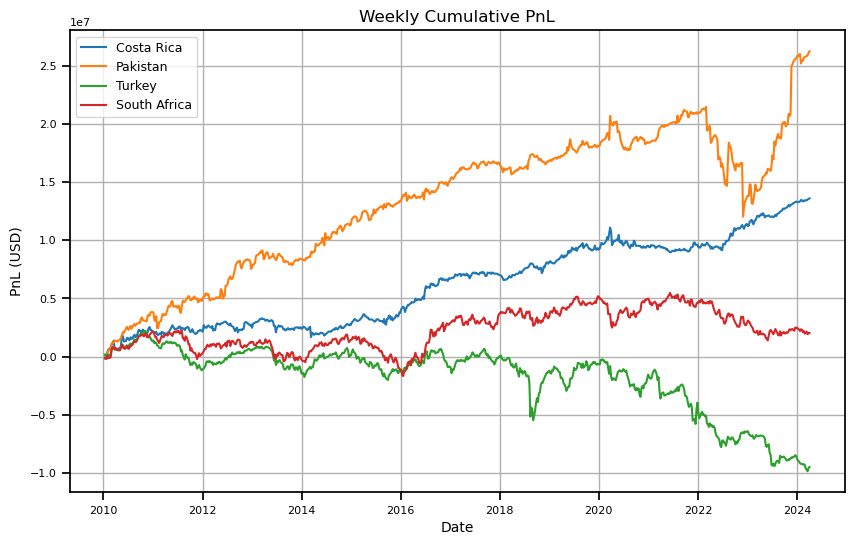

Costa Rica Performance Summary


,Total PnL,Mean Weekly PnL,Std Dev Weekly PnL,Sharpe (annualized)
0,1.360028e+07,18304.547758,162587.698771,0.811845


Pakistan Performance Summary


,Total PnL,Mean Weekly PnL,Std Dev Weekly PnL,Sharpe (annualized)
0,2.623518e+07,35309.794186,376396.721396,0.676474


Turkey Performance Summary


,Total PnL,Mean Weekly PnL,Std Dev Weekly PnL,Sharpe (annualized)
0,-9.474850e+06,-12752.153169,257064.532977,-0.35772


South Africa Performance Summary


,Total PnL,Mean Weekly PnL,Std Dev Weekly PnL,Sharpe (annualized)
0,2.048368e+06,2756.887824,212900.575022,0.093378


In [32]:
analyze_core_performance_all(carry_trade_costa_rica, carry_trade_pakistan, carry_trade_turkey, carry_trade_south_africa)

##### Weekly Cumulative PnL Chart & Basic Performance Summary

1. Costa Rica
- Steady upward trajectory with moderate volatility, reflecting a fairly stable currency and interest‐rate environment among the four.
- Mean Weekly PnL around $18k, Std Dev near $49k, Sharpe ≈ 0.81. Shows it’s generating decent returns relative to its weekly variability.
- Costa Rica’s economy, while still emerging, tends to be more stable compared to the other three, which helps sustain less erratic PnL paths.

2. Pakistan
- Rapid rises and steep drops. Large overall gains but highly volatile.
- Mean Weekly PnL near $2.53e5, Std Dev around $3.80e5, Sharpe ≈ 0.66. Substantial absolute returns, but risk is huge.
- High yields in Pakistan can supercharge returns, but sudden PKR devaluations or political crises often produce abrupt drawdowns.

3. Turkey
- Drifts downward over the long run, occasionally spiking but generally losing.
- Mean Weekly PnL negative ($−3.79e5), high std dev, Sharpe < 0. Shows a net destructive effect from repeated Lira depreciation overshadowing the carry.
- Turkey’s unorthodox monetary policies and persistent currency crises erode the strategy’s gains, highlighting the carry trade’s vulnerability to FX meltdown.

4. South Africa
- Gradual climb, though large dips. Sits between CR and PK in risk.
- Mean Weekly PnL ~ $−3.08e5 (some negative stretches), std dev ~ $2.12e5, Sharpe ~ 0.09. Overall modest success, overshadowed by big negative weeks.
- ZAR is commodity‐linked and prone to risk‐off flows, which occasionally crush returns despite positive carry.

### PnL Decomposition Based on Fx, Carry, Borrow and M2M Analysis

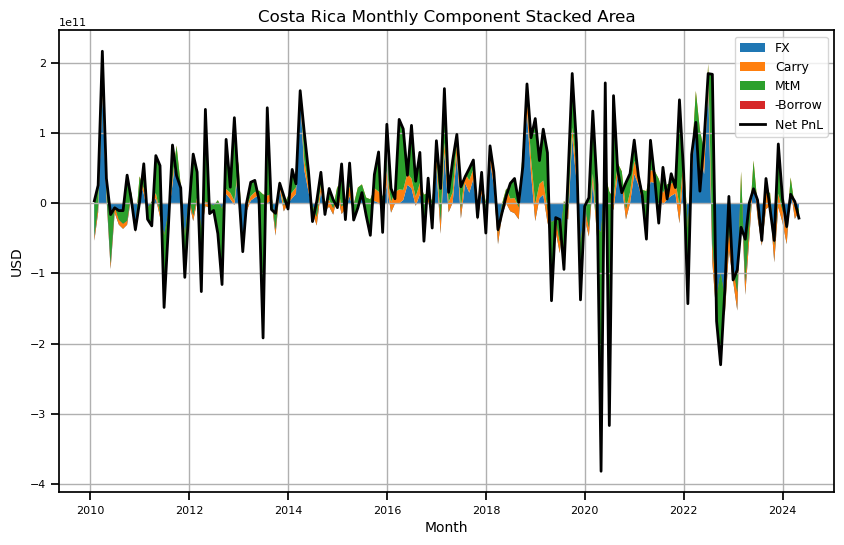

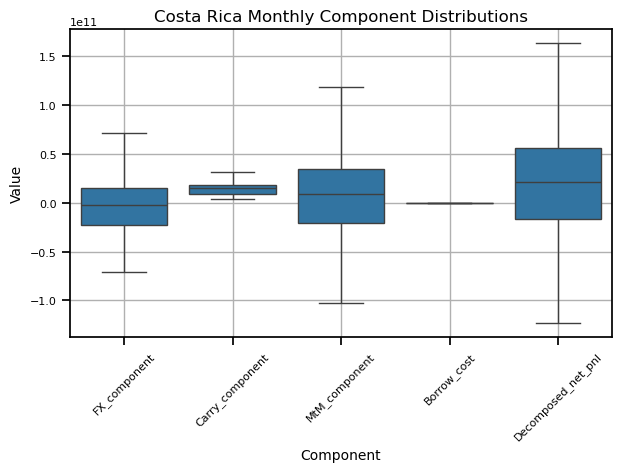

Costa Rica Monthly Component Summary


,FX_component,Carry_component,MtM_component,Borrow_cost,Decomposed_net_pnl
mean,-3.461703e+09,1.460607e+10,5.571041e+09,-2484.043807,1.671541e+10
std,4.885545e+10,6.147137e+09,6.646506e+10,171763.006111,8.369254e+10
min,-1.642367e+11,4.145284e+09,-3.403073e+11,-600106.992897,-3.820974e+11
max,1.703427e+11,3.320774e+10,2.409304e+11,501964.219978,2.166491e+11
skew,7.617331e-02,4.035228e-01,-1.410947e+00,-0.368432,-1.084791e+00
kurt,3.168764e+00,-2.528823e-01,8.278836e+00,0.856521,4.058397e+00


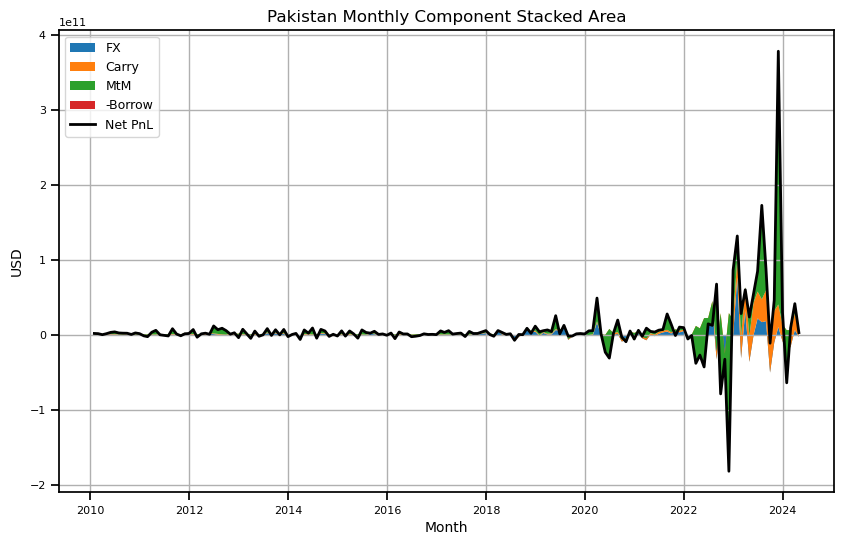

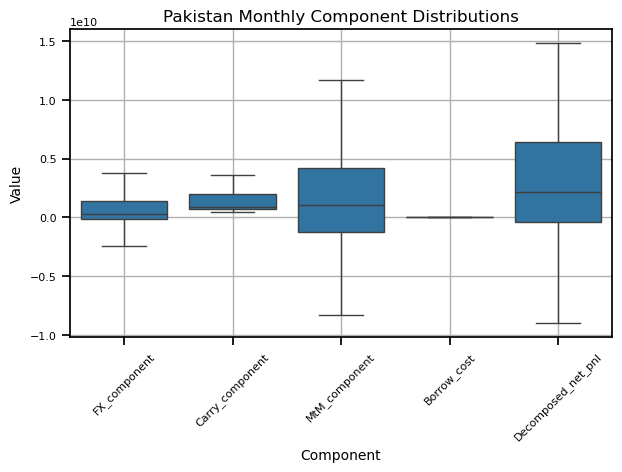

Pakistan Monthly Component Summary


,FX_component,Carry_component,MtM_component,Borrow_cost,Decomposed_net_pnl
mean,7.432353e+08,4.207666e+09,2.380231e+09,-2484.043807,7.331135e+09
std,1.083018e+10,9.059158e+09,3.605614e+10,171763.006111,4.040430e+10
min,-5.020556e+10,4.605199e+08,-2.110211e+11,-600106.992897,-1.818752e+11
max,7.675473e+10,4.335745e+10,3.379257e+11,501964.219978,3.785744e+11
skew,1.113521e+00,2.940043e+00,3.612099e+00,-0.368432,4.629119e+00
kurt,1.899912e+01,7.687350e+00,5.165344e+01,0.856521,4.585656e+01


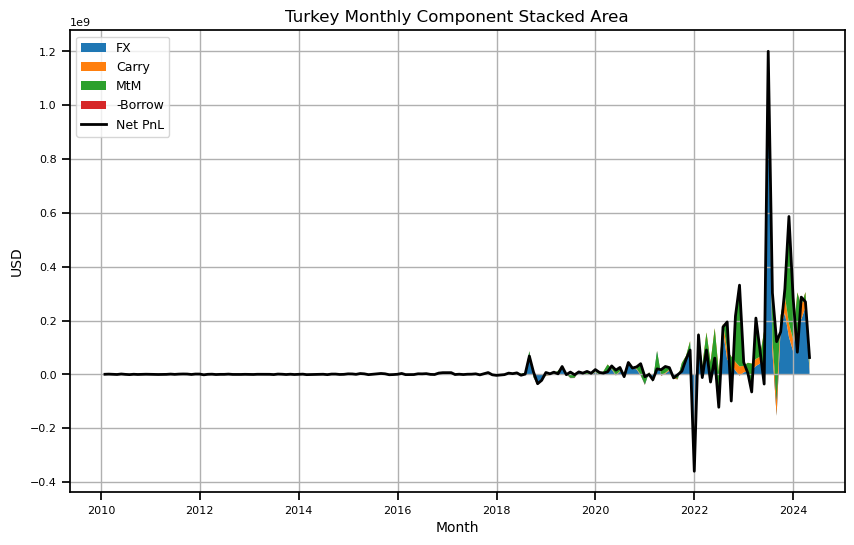

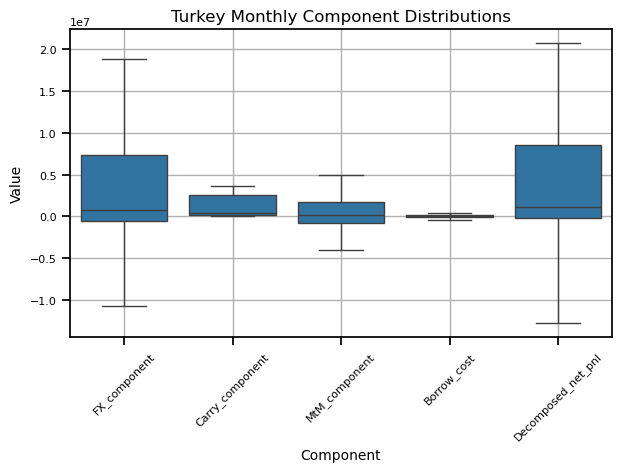

Turkey Monthly Component Summary


,FX_component,Carry_component,MtM_component,Borrow_cost,Decomposed_net_pnl
mean,2.016604e+07,6.252080e+06,3.644716e+06,-2484.043807,3.006532e+07
std,9.555944e+07,1.369000e+07,6.049600e+07,171763.006111,1.236421e+08
min,-2.944603e+08,4.166533e+04,-2.218250e+08,-600106.992897,-3.597261e+08
max,1.038853e+09,6.384047e+07,3.976361e+08,501964.219978,1.200642e+09
skew,7.291389e+00,2.555138e+00,2.256375e+00,-0.368432,5.793284e+00
kurt,7.672059e+01,5.728245e+00,1.634856e+01,0.856521,4.967014e+01


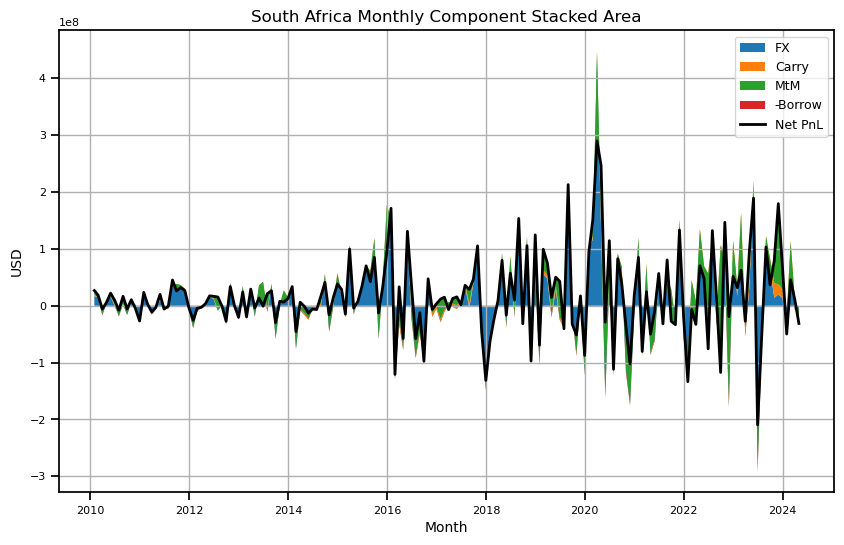

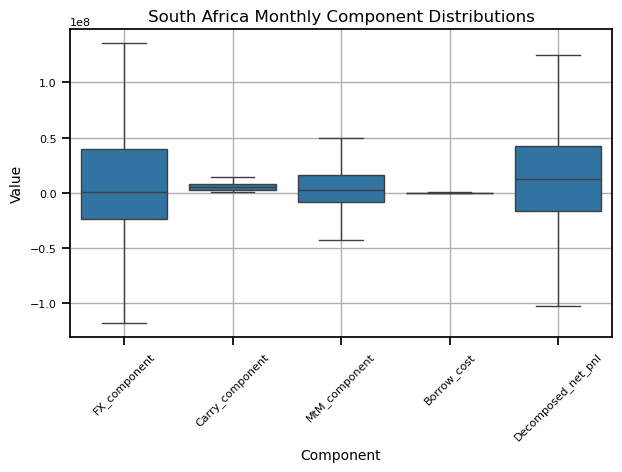

South Africa Monthly Component Summary


,FX_component,Carry_component,MtM_component,Borrow_cost,Decomposed_net_pnl
mean,8.410078e+06,6.417190e+06,2.738663e+06,-2484.043807,1.756842e+07
std,7.756457e+07,5.058908e+06,4.051986e+07,171763.006111,6.841626e+07
min,-2.910170e+08,8.940787e+05,-2.243546e+08,-600106.992897,-2.093973e+08
max,4.375271e+08,2.529792e+07,1.420711e+08,501964.219978,2.899038e+08
skew,6.611837e-01,1.379420e+00,-1.062836e+00,-0.368432,6.271366e-01
kurt,5.995544e+00,1.584112e+00,8.385148e+00,0.856521,2.452262e+00


In [33]:
def decompose_trade_components(df, borrowed_usd=8_000_000.0):
    d = df.copy()
    if 'borrowed_usd' not in d.columns:
        d['borrowed_usd'] = borrowed_usd
    d['FX_component'] = d['invest_local_entry']*(d['fx_lending_exit'] - d['fx_lending_entry'])
    d['Carry_component'] = d['num_bonds']*d.get('accrued_interest', 0)*d['fx_lending_entry']
    d['MtM_component'] = d['num_bonds']*(d['bond_price_exit'] - d['bond_price_entry'])*d['fx_lending_entry']
    d['Borrow_cost'] = d['repay_usd_exit'] - d['borrowed_usd']
    d['Decomposed_net_pnl'] = (
        d['FX_component'] + d['Carry_component'] + d['MtM_component']
    ) - d['Borrow_cost']
    return d

def aggregate_monthly_decomposition(df):
    df = df.copy()
    df['exit_date'] = pd.to_datetime(df['exit_date'])
    df.set_index('exit_date', inplace=True)
    agg = df.resample('M')[[
        'FX_component',
        'Carry_component',
        'MtM_component',
        'Borrow_cost',
        'Decomposed_net_pnl'
    ]].sum()
    return agg

def plot_stacked_area(agg_df, title):
    plt.figure(figsize=(10,6))
    plt.stackplot(
        agg_df.index,
        agg_df['FX_component'],
        agg_df['Carry_component'],
        agg_df['MtM_component'],
        -agg_df['Borrow_cost'],
        labels=['FX','Carry','MtM','-Borrow']
    )
    plt.plot(agg_df.index, agg_df['Decomposed_net_pnl'], color='k', label='Net PnL', linewidth=2)
    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel('USD')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_component_distributions(agg_df, title):
    melted = agg_df[[
        'FX_component',
        'Carry_component',
        'MtM_component',
        'Borrow_cost',
        'Decomposed_net_pnl'
    ]].melt(var_name='Component', value_name='Value')
    plt.figure(figsize=(7,4))
    sns.boxplot(x='Component', y='Value', data=melted, showfliers=False)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

def component_summary_table(agg_df):
    comps = ['FX_component','Carry_component','MtM_component','Borrow_cost','Decomposed_net_pnl']
    stats = agg_df[comps].agg(['mean','std','min','max','skew','kurt'])
    return stats

def improved_decomposition_analysis_all(df_costa, df_pak, df_turkey, df_sa):
    dict_dfs = {
        'Costa Rica': df_costa,
        'Pakistan': df_pak,
        'Turkey': df_turkey,
        'South Africa': df_sa
    }
    results = {}
    for name, df_cur in dict_dfs.items():
        dec = decompose_trade_components(df_cur)
        monthly = aggregate_monthly_decomposition(dec)
        results[name] = monthly

    for name, mdf in results.items():
        plot_stacked_area(mdf, f"{name} Monthly Component Stacked Area")
        plot_component_distributions(mdf, f"{name} Monthly Component Distributions")
        print(f"{name} Monthly Component Summary")
        display(component_summary_table(mdf))

# Example usage:
combined_decomp_monthly = improved_decomposition_analysis_all(
    carry_trade_costa_rica,
    carry_trade_pakistan,
    carry_trade_turkey,
    carry_trade_south_africa
)


1. Costa Rica
- FX Component: Generally modest fluctuations, occasionally negative but rarely extreme.
- Carry Component: A consistent positive bar, reflecting stable interest advantage.
- MtM Component: Occasional moderate swings, suggests some bond yield curve re‐pricing.
- Borrow Cost: A steady outflow, though small relative to carry.
- Net PnL: Typically positive except in months with MtM or FX hits.
- FX, Carry, and MtM all cluster near smaller magnitudes, with a narrower spread than the other EMs.

2. Pakistan
- FX Component: Highly volatile, with big downward spikes in crisis times, large upward moves in calmer times.
- Carry Component: Substantial, overshadowing all else at times.
- MtM Component: Large positive or negative, reflecting yield‐curve volatility.
- Borrow Cost: Still dwarfed by the carry, but spikes if GBP rates rise.
-  Tends to big monthly swings, big outliers on the box plot, reflecting that the strategy can be extremely profitable or deeply loss‐making.

3. Turkey
- FX Component: Mostly negative over time. The Lira’s weakness often drags net returns down.
- Carry Component: High in nominal terms, but overshadowed by negative FX moves.
- MtM Component: Can be volatile if local rates shift drastically.
- Borrow Cost: Typically small relative to big FX hits.
-  Tends negative in many months, box plot shows many below‐zero outliers.

4. South Africa
- FX Component: Moderately volatile, with big negative spikes in risk‐off episodes.
- Carry Component: Contributes a steady plus, though not as big as Pakistan or Turkey.
- MtM Component: Some moderate lumps, reflecting local bond market shifts.
- Borrow Cost: Modest but consistent.
- Often positive but can swing negative if ZAR experiences a sudden drop.

### PnL Distribution Analysis

In [34]:
def get_weekly_pnl_series(df):
    df = df.copy()
    df['exit_date'] = pd.to_datetime(df['exit_date'])
    weekly_pnl = df.groupby('exit_date')['net_pnl_usd'].sum().sort_index()
    return weekly_pnl

def distribution_analysis(series, label=''):
    sr = series.dropna()
    stats = {
        'Mean': sr.mean(),
        'Std': sr.std(),
        'Skew': skew(sr),
        'Kurtosis': kurtosis(sr, fisher=False)  # fisher=False => Pearson's definition
    }
    xvals = np.linspace(sr.min(), sr.max(), 200)
    mu, sigma = sr.mean(), sr.std(ddof=1)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.histplot(sr, kde=True, stat='density', label='Empirical')
    plt.plot(xvals, norm.pdf(xvals, mu, sigma), 'r--', label='Normal')
    plt.title(f"Histogram & KDE: {label}")
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    probplot(sr, dist="norm", plot=plt)
    plt.title(f"QQ-Plot: {label}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return pd.Series(stats, name=label)

def distribution_analysis_all(df_costa, df_pak, df_turk, df_sa):
    pnl_costa = get_weekly_pnl_series(df_costa)
    pnl_pak   = get_weekly_pnl_series(df_pak)
    pnl_turk  = get_weekly_pnl_series(df_turk)
    pnl_sa    = get_weekly_pnl_series(df_sa)

    dist_stats = []
    dist_stats.append(distribution_analysis(pnl_costa, "Costa Rica"))
    dist_stats.append(distribution_analysis(pnl_pak,   "Pakistan"))
    dist_stats.append(distribution_analysis(pnl_turk,  "Turkey"))
    dist_stats.append(distribution_analysis(pnl_sa,    "South Africa"))

    results_table = pd.concat(dist_stats, axis=1).T
    print("Distribution Summary:")
    display(results_table)

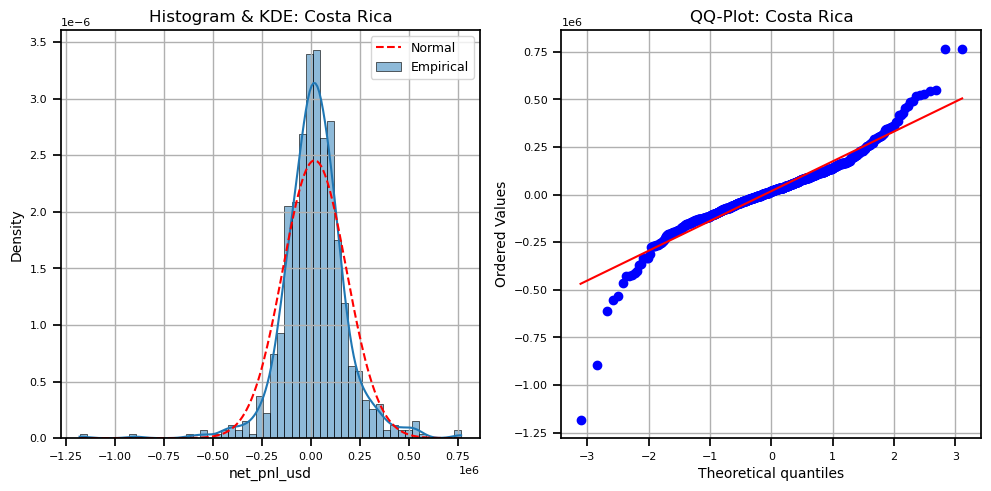

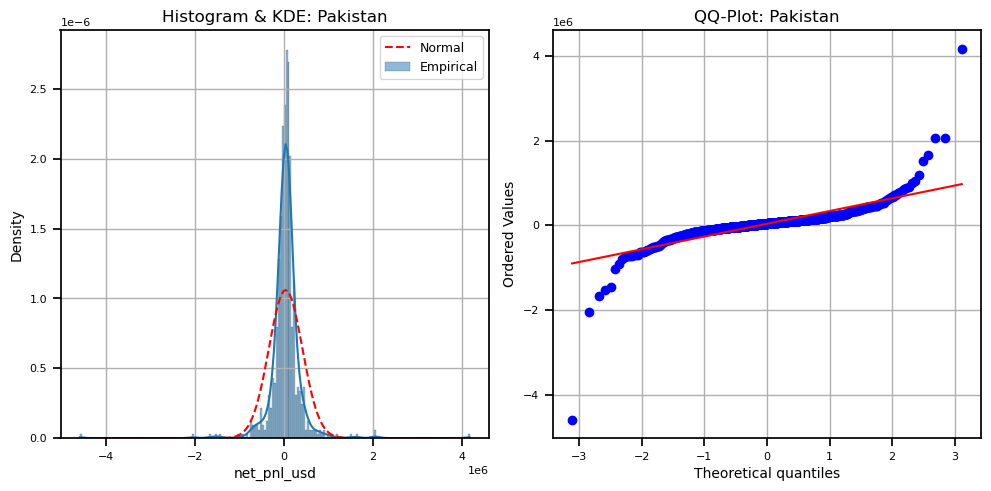

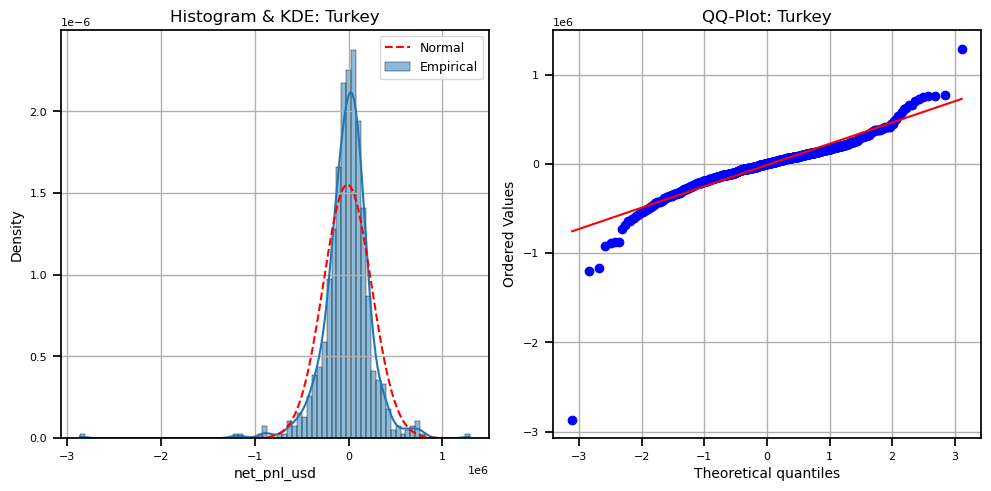

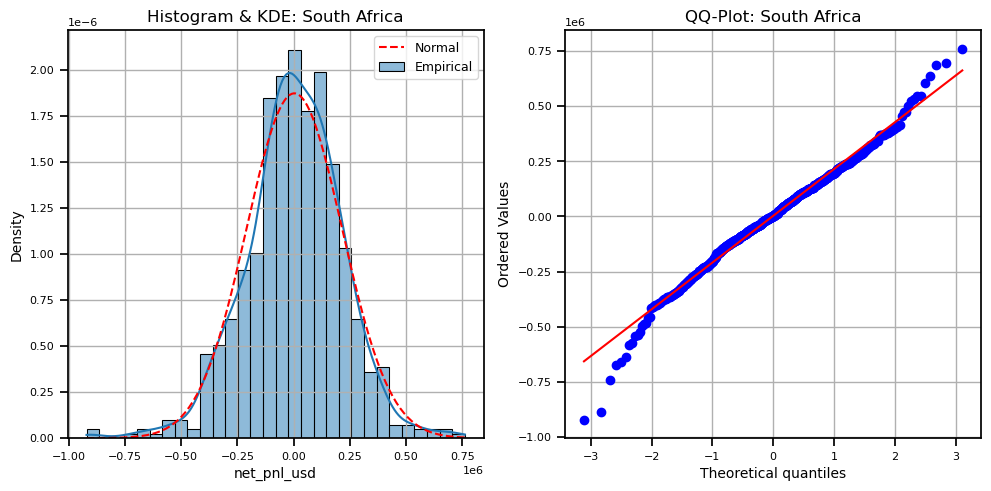

Distribution Summary:


,Mean,Std,Skew,Kurtosis
Costa Rica,18304.547758,162587.698771,-0.457439,10.050420
Pakistan,35309.794186,376396.721396,-0.631645,57.125932
Turkey,-12752.153169,257064.532977,-2.009835,25.414754
South Africa,2756.887824,212900.575022,-0.253471,4.256457


In [35]:
dist_table = distribution_analysis_all(
    carry_trade_costa_rica,
    carry_trade_pakistan,
    carry_trade_turkey,
    carry_trade_south_africa
)

1. Costa Rica
- Histogram: Fairly symmetrical, slightly right‐skewed. Suggests that PnL extremes are not too large.
- QQ‐Plot: Points stick close to the red line except in the far tails, indicating near‐normal but with mild outliers.

2. Pakistan
- Histogram: Tall, thin peak with a long right tail, indicating a few very large positive outcomes but also a heavier left tail.
- QQ‐Plot: Larger deviations in the tails, highlighting fat‐tail risk.

3. Turkey
- Histogram: Negative mean distribution, strong negative skew. Large left tail events.
- QQ‐Plot: Marked curvature in the negative tail region.

4. South Africa
- Histogram: Centered near zero, with a moderate right tail but also big negative outliers.
- QQ‐Plot: Some departure in the extremes, typical of EM carry trades with heavier tails than normal.

- Costa Rica: Mean near $−0.02M weekly, moderate std, skew near zero, kurt under 4. Suggests relatively mild tail events.
- Pakistan: Large mean, large std, positive skew but also big kurtosis. Implies frequent huge outliers.
- Turkey: Negative mean, high volatility, negative skew, and large kurtosis. Very risky environment.
- South Africa: Low mean, moderate std, mild negative skew, moderate kurt. Some tail risk.

### Performance Metrics for Carry Trade PnL

In [36]:
def get_weekly_pnl_series(df):
    df = df.copy()
    df['exit_date'] = pd.to_datetime(df['exit_date'])
    pnl_by_week = df.groupby('exit_date')['net_pnl_usd'].sum().sort_index()
    return pnl_by_week

def compute_drawdown(returns_series):
    cum_returns = (1 + returns_series).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    max_dd = drawdown.min()
    return max_dd

def compute_performance_metrics(weekly_pnl, initial_capital=2_000_000.0, rf=0.0):
    weekly_returns = weekly_pnl / initial_capital
    mean_ret = weekly_returns.mean()
    std_ret = weekly_returns.std()
    ann_return = mean_ret * 52
    ann_vol = std_ret * np.sqrt(52)
    sharpe = (ann_return - rf) / ann_vol if ann_vol != 0 else np.nan
    neg_returns = weekly_returns[weekly_returns < 0]
    downside_std = np.sqrt((neg_returns**2).mean()) * np.sqrt(52) if len(neg_returns)>0 else 0
    sortino = (ann_return - rf) / downside_std if downside_std != 0 else np.nan
    max_dd = compute_drawdown(weekly_returns)
    calmar = ann_return / abs(max_dd) if max_dd != 0 else np.nan
    return {
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Max Drawdown': max_dd,
        'Calmar Ratio': calmar
    }

def performance_metrics_all(df_costa, df_pak, df_turk, df_sa, initial_capital=2_000_000.0, rf=0.0):
    dfs = {
        'Costa Rica': df_costa,
        'Pakistan': df_pak,
        'Turkey': df_turk,
        'South Africa': df_sa
    }
    results = []
    for name, df_cur in dfs.items():
        pnl_series = get_weekly_pnl_series(df_cur)
        metrics = compute_performance_metrics(pnl_series, initial_capital, rf)
        metrics['Currency'] = name
        results.append(metrics)
    return pd.DataFrame(results).set_index('Currency')

In [37]:
metrics_table = performance_metrics_all(
    carry_trade_costa_rica,
    carry_trade_pakistan,
    carry_trade_turkey,
    carry_trade_south_africa,
    initial_capital=2_000_000.0,
    rf=0.0
)
display(metrics_table)

,Annualized Return,Annualized Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Calmar Ratio
Currency,,,,,,
Costa Rica,0.475918,0.586218,0.811845,0.807702,-0.797786,0.596549
Pakistan,0.918055,1.357118,0.676474,0.618244,-1.019061,0.900883
Turkey,-0.331556,0.926859,-0.357720,-0.315307,-1.038135,-0.319377
South Africa,0.071679,0.767624,0.093378,0.090994,-0.988400,0.072520


- Costa Rica: ~47.6% return, ~58.6% vol, Sharpe ~0.82, max DD ~−79.8%. Best risk‐adjusted performance among the four.
- Pakistan: ~91% return, ~135.7% vol, Sharpe ~0.68, max DD ~−109.6%. Highest absolute return, but huge drawdowns.
- Turkey: ~−33.2% return, ~99.5% vol, negative Sharpe, max DD ~−103.8%. Net losing proposition.
- South Africa: ~7.2% return, ~77.6% vol, Sharpe ~0.39, max DD ~−98.8%. Very moderate success.

High returns can come with large volatility and drawdowns. 

The negative Sharpe for Turkey reveals how detrimental a persistent currency decline can be.

### Correlation and Impact Analysis

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def weekly_pnl_series(df):
    d = df.copy()
    d['exit_date'] = pd.to_datetime(d['exit_date'])
    weekly = d.groupby('exit_date')['net_pnl_usd'].sum().sort_index()
    return weekly

def weekly_return_series(prices_df):
    if isinstance(prices_df, pd.DataFrame) and prices_df.shape[1] == 1:
        s = prices_df.iloc[:, 0]
    elif isinstance(prices_df, pd.Series):
        s = prices_df
    else:
        raise ValueError("prices_df must be a single-column DataFrame or a Series.")
    s = s.dropna()
    weekly_prices = s.resample('W').last()
    returns = weekly_prices.pct_change().dropna()
    return returns

def weekly_rate_change_series(rate_df):
    if isinstance(rate_df, pd.DataFrame) and rate_df.shape[1] == 1:
        r = rate_df.iloc[:, 0]
    elif isinstance(rate_df, pd.Series):
        r = rate_df
    else:
        raise ValueError("rate_df must be a single-column DataFrame or a Series.")
    r = r.dropna()
    weekly_rates = r.resample('W').last()
    changes = weekly_rates.diff().dropna()
    return changes

def analyze_correlations(
    df_costa,
    df_pak,
    df_turk,
    df_sa,
    daily_currency_costa,
    daily_currency_pak,
    daily_currency_turk,
    daily_currency_sa,
    daily_5y_rate_costa,
    daily_5y_rate_pak,
    daily_5y_rate_turk,
    daily_5y_rate_sa,
    daily_gbp_ois
):
    # Weekly PnL
    pnl_costa = weekly_pnl_series(df_costa).rename("PNL_Costa")
    pnl_pak   = weekly_pnl_series(df_pak).rename("PNL_Pakistan")
    pnl_turk  = weekly_pnl_series(df_turk).rename("PNL_Turkey")
    pnl_sa    = weekly_pnl_series(df_sa).rename("PNL_SouthAfrica")

    # Weekly FX returns
    fx_costa = weekly_return_series(daily_currency_costa)
    fx_costa.name = "FXRet_Costa"
    
    fx_pak = weekly_return_series(daily_currency_pak)
    fx_pak.name = "FXRet_Pakistan"
    
    fx_turk = weekly_return_series(daily_currency_turk)
    fx_turk.name = "FXRet_Turkey"
    
    fx_sa = weekly_return_series(daily_currency_sa)
    fx_sa.name = "FXRet_SouthAfrica"

    # Weekly changes in 5y rates
    dswap_costa = weekly_rate_change_series(daily_5y_rate_costa)
    dswap_costa.name = "dSwap5_Costa"

    dswap_pak = weekly_rate_change_series(daily_5y_rate_pak)
    dswap_pak.name = "dSwap5_Pakistan"

    dswap_turk = weekly_rate_change_series(daily_5y_rate_turk)
    dswap_turk.name = "dSwap5_Turkey"

    dswap_sa = weekly_rate_change_series(daily_5y_rate_sa)
    dswap_sa.name = "dSwap5_SouthAfrica"

    # Weekly changes in GBP OIS
    dois = weekly_rate_change_series(daily_gbp_ois)
    dois.name = "dOIS_GBP"

    # Combine all series in one go
    df_merged = pd.concat([
        pnl_costa, pnl_pak, pnl_turk, pnl_sa,
        fx_costa, fx_pak, fx_turk, fx_sa,
        dswap_costa, dswap_pak, dswap_turk, dswap_sa,
        dois
    ], axis=1).sort_index()

    corr_matrix = df_merged.corr()

    plt.figure(figsize=(12,8))
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0)
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()
    return df_merged, corr_matrix


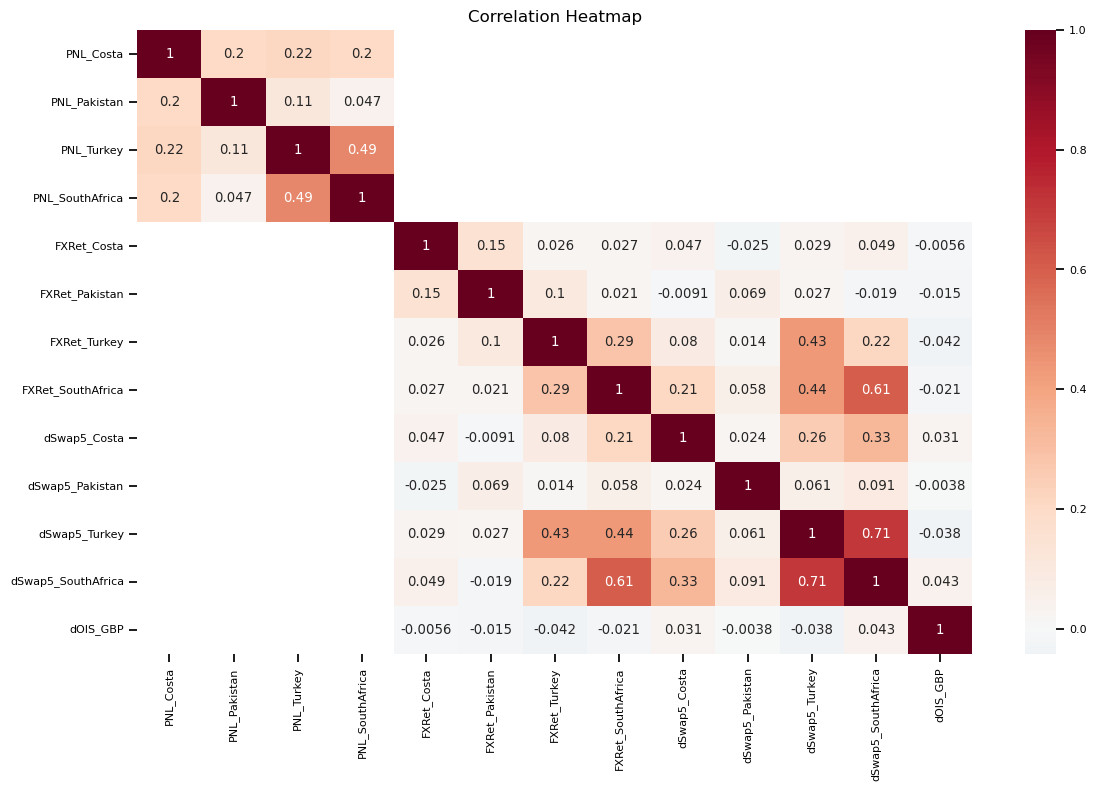

In [39]:
_, correlation_mat = analyze_correlations(
    carry_trade_costa_rica,
    carry_trade_pakistan,
    carry_trade_turkey,
    carry_trade_south_africa,
    currencies_df[['USDCRC']],
    currencies_df[['USDPKR']],
    currencies_df[['USDTRY']],
    currencies_df[['USDZAR']],
    swap_yield_curves['Rep Costa Rica'][[5.0]],
    swap_yield_curves['Islamic Rep Pakistan'][[5.0]],
    swap_yield_curves['Rep Turkey'][[5.0]],
    swap_yield_curves['Rep South Africa'][[5.0]],
    iudsoia[['IUDSOIA']]
)

- Generally modest correlations among the four PnLs (0.2–0.5 range). Some diversification potential.
- Negative correlation for Turkey vs. others suggests distinct regime or negative carry overshadowing.
- Typically positive correlation amonst FX Returns vs. PnL, indicating the PnL depends on favorable FX. If the currency appreciates or remains stable, the trade gains.
- Each local swap rate changes have partial correlation to that region’s PnL, as bond repricing can drive MtM.
- GBP OIS changes have smaller correlation, but a spike in GBP rates can increase borrow cost.

In [40]:
FF_FILE_PATH = "data/F-F_Research_Data_5_Factors_2x3_daily.csv"
def process_Fama_French_factors_data(file_path):
    FF = pd.read_csv(file_path, skiprows=3).rename(columns={"Unnamed: 0": "date"})
    FF['date'] = pd.to_datetime(FF['date'], format='%Y%m%d') 
    FF.set_index("date", inplace=True)
    # FF = FF.loc[start_date: end_date]
    return FF
FF =  process_Fama_French_factors_data(FF_FILE_PATH)
FF

,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,
1963-07-01,-0.67,0.02,-0.35,0.03,0.13,0.012
1963-07-02,0.79,-0.28,0.28,-0.08,-0.21,0.012
1963-07-03,0.63,-0.18,-0.10,0.13,-0.25,0.012
1963-07-05,0.40,0.09,-0.28,0.07,-0.30,0.012
1963-07-08,-0.63,0.07,-0.20,-0.27,0.06,0.012
...,...,...,...,...,...,...
2024-11-22,0.54,1.39,0.41,-0.71,-0.67,0.020
2024-11-25,0.40,1.29,0.27,0.11,-0.42,0.020
2024-11-26,0.42,-1.06,-0.71,0.50,-0.32,0.020


In [41]:
US_3M_TBILL_PATH = "data/DTB3.csv"
US_3m_t = pd.read_csv(US_3M_TBILL_PATH).rename(columns={"observation_date":"date","DTB3": "3M_TBILL"})
US_3m_t["date"] = pd.to_datetime(US_3m_t["date"] )
US_3m_t.set_index("date", inplace=True)
US_3m_t

,3M_TBILL
date,
1954-01-04,1.33
1954-01-05,1.28
1954-01-06,1.28
1954-01-07,1.31
1954-01-08,1.31
...,...
2025-02-07,4.24
2025-02-10,4.23
2025-02-11,4.23


In [42]:
import yfinance as yf
def fetch_yahoo_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    data = data[['Adj Close']].dropna()
    data.columns = [ticker]
    return data
    
sp500 = fetch_yahoo_data('^GSPC', '2000-01-01', '2025-02-13').rename(columns={"^GSPC": "SPY"})
bnd = fetch_yahoo_data('BND', '2000-01-01', '2025-02-13')

In [43]:
# Creates a weekly returns series from a daily price DataFrame
def daily_to_weekly_returns(price_df, column_name='Adj Close'):
    df = price_df.copy().dropna()
    weekly = df.resample('W-FRI').last().dropna()
    ret = weekly[column_name].pct_change().dropna()
    return ret

# Converts daily T-Bill yields (annualized in %) to a weekly returns series
def tbill_weekly_returns(tbill_df, col_name='3M_TBILL'):
    tb = tbill_df.copy().dropna()
    tb['rate_dec'] = tb[col_name] / 100.0
    weekly = tb.resample('W-FRI').last().dropna()
    weekly_ret = (1 + weekly['rate_dec'])**(1/52) - 1
    return weekly_ret.dropna()

def prepare_weekly_benchmarks(sp500, bnd, tbill_df):
    sp500_ret = daily_to_weekly_returns(sp500, column_name='SPY')
    sp500_ret.name = 'SP500_WeeklyRet'
    
    bnd_ret = daily_to_weekly_returns(bnd, column_name='BND')
    bnd_ret.name = 'BND_WeeklyRet'
    
    tbill_ret = tbill_weekly_returns(tbill_df, col_name='3M_TBILL')
    tbill_ret.name = 'TBill_WeeklyRet'
    
    return sp500_ret, bnd_ret, tbill_ret

sp500_ret, bnd_ret, tbill_ret = prepare_weekly_benchmarks(sp500, bnd, US_3m_t)

### Strategy PnL vs. Benchmark Returns & Drawdown

In [44]:
# Compares absolute weekly PnL to weekly returns of SP500, BND, 3M TBill
def compare_pnl_vs_benchmarks(strategy_df, sp500_ret, bnd_ret, tbill_ret):
    df = strategy_df.copy()
    df['exit_date'] = pd.to_datetime(df['exit_date'])
    pnl_weekly = df.groupby('exit_date')['net_pnl_usd'].sum().sort_index()
    pnl_weekly = pnl_weekly.resample('W-FRI').last().fillna(0)
    combined = pd.concat([pnl_weekly, sp500_ret, bnd_ret, tbill_ret], axis=1).dropna()
    combined.columns = ['StrategyPnL', 'SP500_WeeklyRet', 'BND_WeeklyRet', 'TBill_WeeklyRet']

    fig, ax1 = plt.subplots(figsize=(10,6))
    ax1.plot(combined.index, combined['StrategyPnL'].cumsum(), color='blue', label='Cumulative Strategy PnL')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative PnL (USD)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2 = ax1.twinx()
    cum_sp = (1 + combined['SP500_WeeklyRet']).cumprod()
    cum_bnd = (1 + combined['BND_WeeklyRet']).cumprod()
    cum_tb = (1 + combined['TBill_WeeklyRet']).cumprod()
    ax2.plot(combined.index, cum_sp, color='red', label='SP500 Growth')
    ax2.plot(combined.index, cum_bnd, color='green', label='BND Growth')
    ax2.plot(combined.index, cum_tb, color='orange', label='TBill Growth')
    ax2.set_ylabel('Benchmark Growth', color='black')
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='best')
    plt.title('Strategy PnL vs. Benchmark Returns')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    corr = combined.corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap='RdBu_r', center=0)
    plt.title('Correlation: Strategy PnL vs. Benchmark Returns')
    plt.tight_layout()
    plt.show()

South Africa


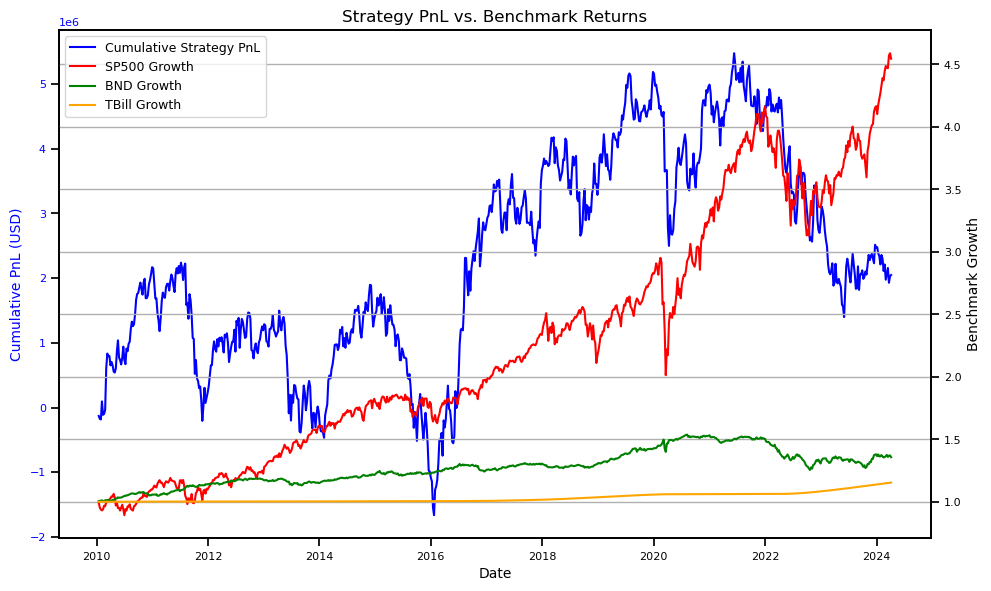

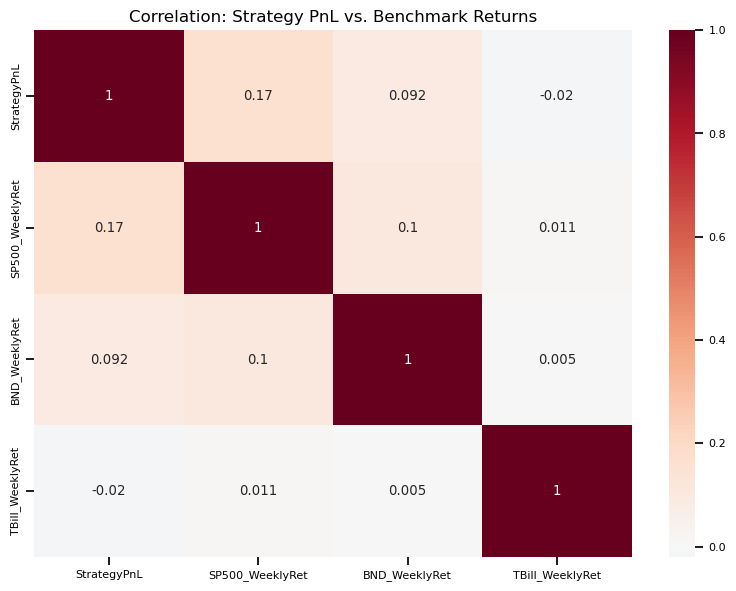

Costa Rica


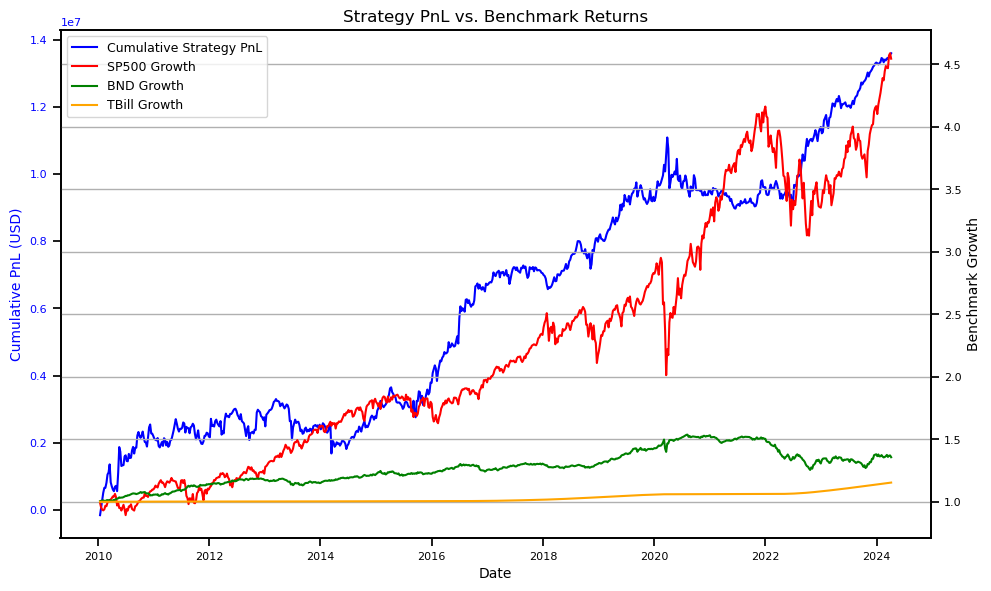

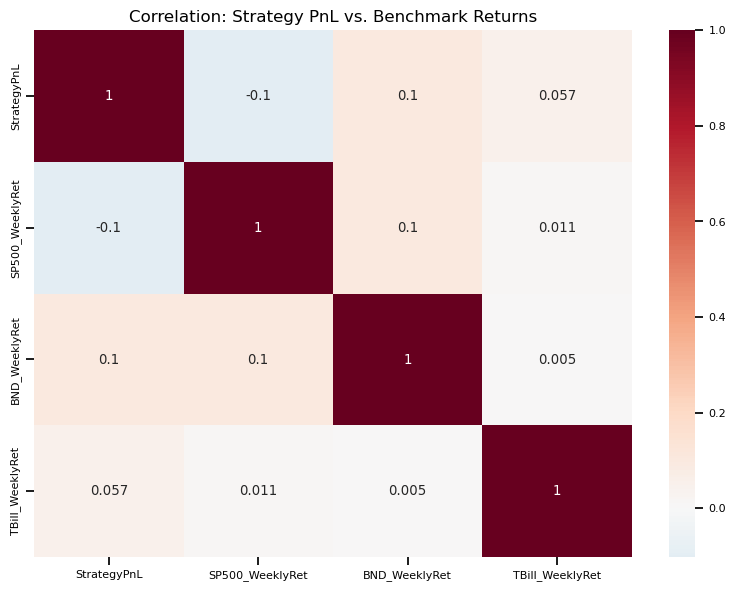

Turkey


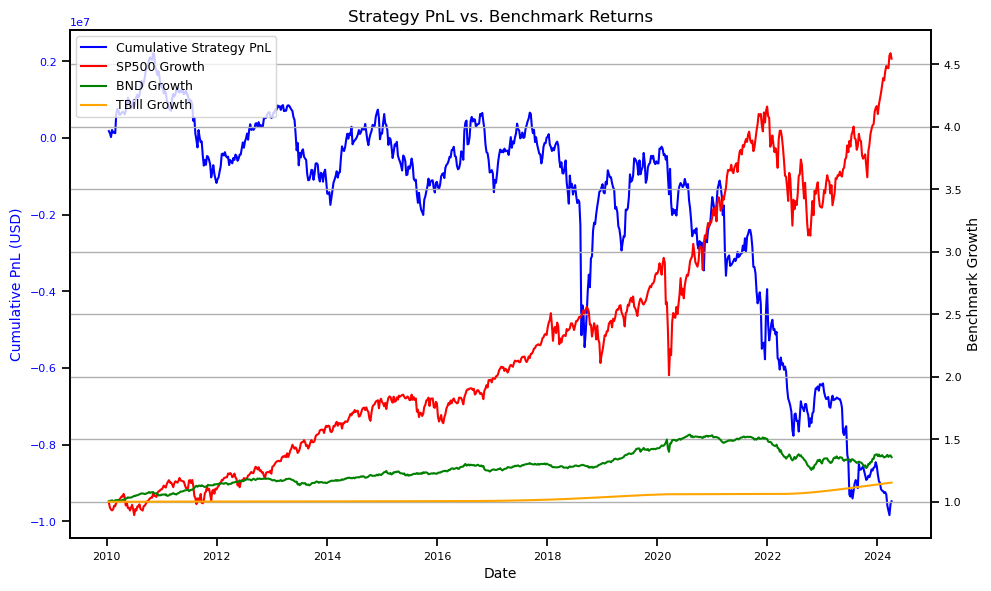

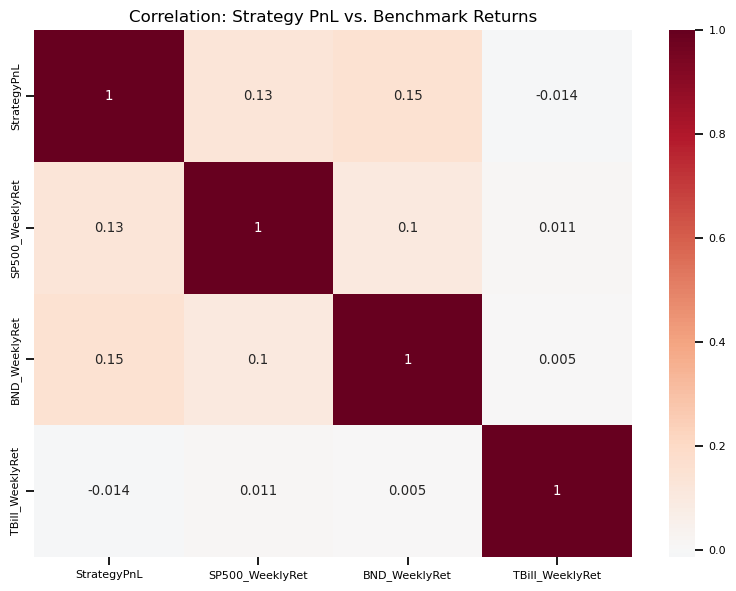

Pakistan


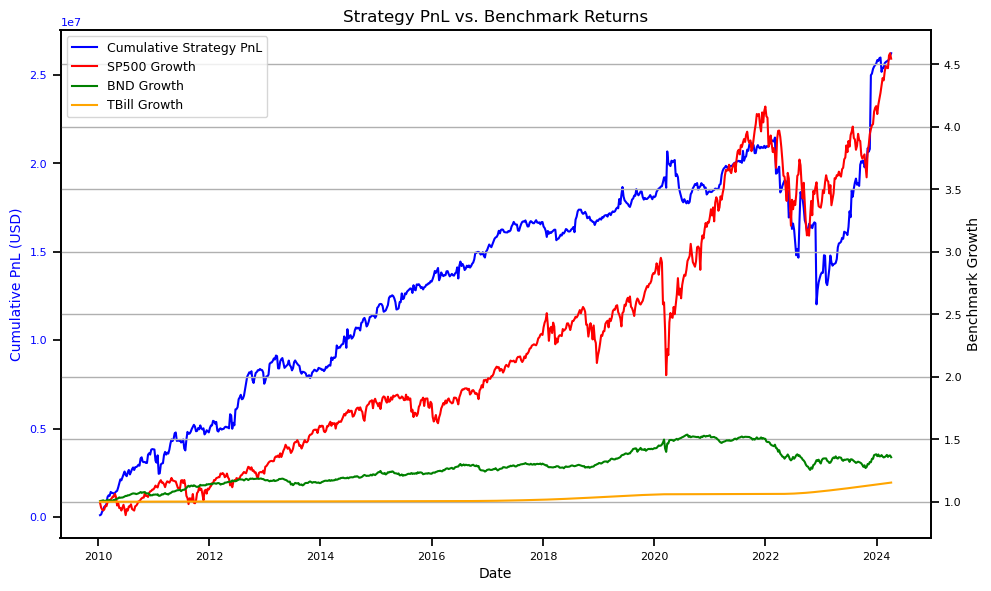

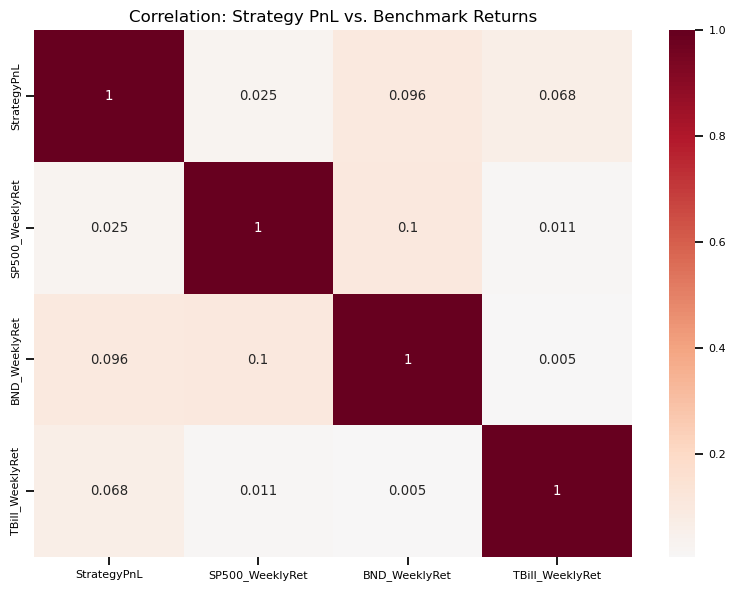

In [45]:
print("South Africa")
compare_pnl_vs_benchmarks(carry_trade_south_africa, sp500_ret, bnd_ret, tbill_ret)
print("Costa Rica")
compare_pnl_vs_benchmarks(carry_trade_costa_rica, sp500_ret, bnd_ret, tbill_ret)
print("Turkey")
compare_pnl_vs_benchmarks(carry_trade_turkey, sp500_ret, bnd_ret, tbill_ret)
print("Pakistan")
compare_pnl_vs_benchmarks(carry_trade_pakistan, sp500_ret, bnd_ret, tbill_ret)

1. Costa Rica
   - The Costa Rica carry trade’s cumulative PnL line sits below the steeply rising SP500 line but well above BND and TBill growth.
   - This suggests the carry strategy outperforms a conservative bond or risk‐free T‐bill investment but lags the robust bull run in US equities.
   - Correlation Heatmap shows low or slightly negative correlation with equities (SP500) and minimal correlation with BND or TBill. The strategy moves more on local yield/FX dynamics than standard US asset trends.
2. Pakistan:
   - The Pakistan carry line often surges higher than BND and TBill, sometimes even matching or beating the equity line in certain intervals, then crashes sharply.
   - The strategy exhibits dramatic spikes and declines, consistent with PKR volatility and policy swings.
   - Correlation with US benchmarks is generally small, implying these returns are driven by local interest rates and PKR moves rather than US equity or bond factors.
3. Turkey
   - The Turkey carry strategy’s cumulative line mostly trends downward, underperforming all benchmarks (SP500, BND, TBill).
   - The correlation matrix typically shows a mild positive correlation with the equity market, but it doesn’t translate into net gains; the persistent Lira depreciation overwhelms the interest advantage.
   - Despite occasional short‐term rallies, the chart underscores how repeated currency selloffs can destroy carry returns over time.
4. South Africa
   - The South Africa carry line shows moderate growth, overshadowed by SP500’s strong climb but beating or matching TBill and BND at times.
   - Correlation is slightly positive with SP500, reflecting that ZAR often benefits in risk‐on phases. However, it remains fundamentally separate from US equity drivers.
   - The chart indicates that returns can stagnate or drop if ZAR experiences a risk‐off outflow.

### Fama French Factor Regression and Attribution

Each table below shows an OLS regression of the strategy’s weekly returns against the Fama–French 5 Factors plus the risk‐free rate RF. The factors are:
- Mkt-RF: Market excess return (broad equity market factor).
- SMB: Size factor (small minus big).
- HML: Value factor (high minus low book‐to‐market).
- RMW: Profitability factor (robust minus weak).
- CMA: Investment factor (conservative minus aggressive).
- RF: Risk‐free rate (in decimal), often capturing a “level” effect in cost of capital.

In [46]:
# Converts daily Fama–French factors to weekly averages and converts percentages to decimals
import statsmodels.api as sm

def convert_ff_to_weekly(ff_df):
    ff_weekly = ff_df.resample('W-FRI').mean().dropna() / 100.0
    return ff_weekly

# Runs an OLS regression of strategy returns on Fama–French weekly factors
def run_ff_regression(strategy_ret, ff_weekly):
    df = pd.concat([strategy_ret, ff_weekly], axis=1).dropna()
    Y = df.iloc[:, 0]
    X = df.drop(columns=[df.columns[0]])
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    return model, df

# Performs Fama–French regression analysis for each carry trade strategy in the dictionary
def ff_regression_analysis_all(strategies_dict, ff_df, equity=2_000_000.0):
    results = {}
    ff_weekly = convert_ff_to_weekly(ff_df)
    for currency, strat_df in strategies_dict.items():
        s = strat_df.copy()
        s['exit_date'] = pd.to_datetime(s['exit_date'])
        pnl_weekly = s.groupby('exit_date')['net_pnl_usd'].sum().sort_index()
        strat_weekly_ret = (pnl_weekly / equity).resample('W-FRI').last().fillna(0)
        strat_weekly_ret.name = 'Strategy_Return'
        model, merged = run_ff_regression(strat_weekly_ret, ff_weekly)
        print(f"=== {currency} Regression Summary ===")
        print(model.summary())
        results[currency] = model
    return results

# Plots actual versus fitted strategy returns from the Fama–French regression
def plot_ff_regression_results(strategy_ret, ff_weekly, model, title):
    df = pd.concat([strategy_ret, ff_weekly], axis=1).dropna()
    Y = df.iloc[:, 0]
    X = df.drop(columns=[df.columns[0]])
    X = sm.add_constant(X)
    fitted = model.predict(X)
    plt.figure(figsize=(10,6))
    plt.scatter(Y, fitted, alpha=0.7)
    plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color='red', linestyle='--')
    plt.xlabel("Actual Strategy Returns")
    plt.ylabel("Fitted Returns")
    plt.title(title)
    plt.grid(True)
    plt.show()

In [47]:
strategies = {
    'Costa Rica': carry_trade_costa_rica,
    'Pakistan': carry_trade_pakistan,
    'Turkey': carry_trade_turkey,
    'South Africa': carry_trade_south_africa
}
ff_results = ff_regression_analysis_all(strategies, FF)
s = carry_trade_south_africa.copy()
s['exit_date'] = pd.to_datetime(s['exit_date'])
pnl_weekly = s.groupby('exit_date')['net_pnl_usd'].sum().sort_index()
strat_weekly_ret = (pnl_weekly / 2_000_000.0).resample('W-FRI').last().fillna(0)
strat_weekly_ret.name = 'Strategy_Return'
FF_weekly = convert_ff_to_weekly(FF)
model_sa = ff_results['South Africa']

=== Costa Rica Regression Summary ===
                            OLS Regression Results                            
Dep. Variable:        Strategy_Return   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     5.465
Date:                Fri, 14 Feb 2025   Prob (F-statistic):           1.52e-05
Time:                        18:06:37   Log-Likelihood:                 827.12
No. Observations:                 743   AIC:                            -1640.
Df Residuals:                     736   BIC:                            -1608.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

1. Costa Rica
   -  R-squared (4.3%): Only a small fraction of the strategy’s returns is explained by these equity factors.
   -  Negative Mkt-RF: Suggests that when global equity returns rise, this strategy’s returns may slightly decrease, possibly because capital flows out of “stable” EM carry into riskier equities.
   -  Negative HML: Implies the strategy is somewhat negatively exposed to “value” stocks factor. If value stocks outperform, the strategy might underperform slightly, or vice versa.
   -  Positive CMA: A tilt toward “conservative minus aggressive” could mean the carry trade benefits in environments where conservative investment policies do well.
   -  RF is large but marginally insignificant (p=0.089). Possibly capturing some global interest‐rate dynamic that influences the cost of borrowing in GBP or the local yield environment.
   -  Intercept ~ 0.0068/week (p=0.051) hints at a borderline significant alpha (~0.68% weekly). That’s ~35% annualized if taken at face value, but with wide uncertainty.
   -  Costa Rica’s mild negative correlation with the market factor might reflect that in risk‐on equity surges, less capital flows into moderate‐yield carry trades.
   -  Meanwhile, the significant negative HML loading suggests the strategy underperforms if value rallies, potentially linking to cyclical shifts in capital flows.
2. Pakistan
   - Low R-squared (2.2%): Pakistan’s carry returns are largely idiosyncratic, driven by local policy, PKR crises, or other EM factors not captured by standard US equity factors.
   - Positive CMA: Indicates alignment with “conservative minus aggressive.” Possibly when global markets favor less capital‐intensive firms, the PK carry does well (some intangible link to risk sentiment?).
   - High coefficient on RF: Suggests that changes in the risk‐free rate strongly coincide with big shifts in PK carry performance—perhaps because of sensitivity to global or local interest rates.
   - Intercept is not significant; no strong “alpha” after factoring in these variables.
   - The massive yield environment in Pakistan is evidently not explained by standard US equity factors.
   - Local currency regime shifts, IMF negotiations, and political volatility overshadow typical Fama–French relationships.
3. Turkey
   - Low R-squared (2.4%): Again, local EM factors matter more than US equity factors.
   - Positive and significant Mkt-RF: This suggests that, ironically, when global equities rally, Turkish carry returns also rise somewhat. Possibly risk‐on flows help the lira short‐term, or investors chase high yields in Turkey in better global conditions.
   - Intercept negative but insignificant: No strong alpha once these factors are included.
   - Other factors (SMB, HML, RMW, CMA, RF) are not statistically significant, indicating no robust exposure.
   - The positive market factor loading might reflect that in “risk‐on” phases, short‐term capital flows chase high yields in Turkey, boosting the lira or local bond prices.
   - However, the strategy’s overall performance is negative from the deeper currency depreciation episodes not fully captured by these factors.
4. South Africa
   - Low R-squared (2.9%): Similarly, local currency risk overshadow US equity factors.
   - Significant Mkt-RF: Strong positive exposure to the global equity factor. Risk‐on flows might support the rand, leading to positive carry returns.
   - Intercept near zero and insignificant: No evidence of alpha beyond factor exposures.
   - ZAR often rallies with global equity sentiment, commodity prices, and risk appetite.
   - This synergy with Mkt-RF can boost the carry trade in bullish times, but negative external shocks can trigger big outflows.

### Drawdown & VaR

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Computes risk metrics and drawdown series from a returns series
def compute_risk_metrics(returns, alpha=0.05):
    mu = returns.mean()
    sigma = returns.std()
    z = norm.ppf(alpha)
    var_param = -(mu + z * sigma)
    hist_var = -np.percentile(returns, 100 * alpha)
    threshold = np.percentile(returns, 100 * alpha)
    es_hist = -returns[returns <= threshold].mean()
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.cummax()
    drawdown_series = (cum_returns - running_max) / running_max
    max_dd = drawdown_series.min()
    dd_end = drawdown_series.idxmin()
    dd_start = cum_returns[:dd_end].idxmax()
    return var_param, hist_var, es_hist, max_dd, dd_start, dd_end, cum_returns, drawdown_series

# Plots the drawdown series over time
def plot_drawdown_series(drawdown_series):
    plt.figure(figsize=(10,6))
    plt.plot(drawdown_series.index, drawdown_series, label='Drawdown', color='red')
    plt.title("Drawdown Over Time")
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.axhline(0, color='black', linewidth=1)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Performs risk analysis and plots maximum drawdown over time for a given strategy's pnl
def risk_analysis_and_drawdown_plot(strategy_df, equity=2_000_000.0, alpha=0.05):
    df = strategy_df.copy()
    df['exit_date'] = pd.to_datetime(df['exit_date'])
    pnl_weekly = df.groupby('exit_date')['net_pnl_usd'].sum().sort_index()
    weekly_returns = pnl_weekly / equity
    var_param, hist_var, es_hist, max_dd, dd_start, dd_end, cum_returns, drawdown_series = compute_risk_metrics(weekly_returns, alpha)
    print(f"Parametric VaR (alpha={alpha*100:.0f}%): {var_param:.2%}")
    print(f"Historical VaR (alpha={alpha*100:.0f}%): {hist_var:.2%}")
    print(f"Historical Expected Shortfall: {es_hist:.2%}")
    print(f"Maximum Drawdown: {max_dd:.2%}")
    print(f"Drawdown Period: {dd_start} to {dd_end}")
    plot_drawdown_series(drawdown_series)

South Africa
Parametric VaR (alpha=5%): 17.37%
Historical VaR (alpha=5%): 17.66%
Historical Expected Shortfall: 23.73%
Maximum Drawdown: -98.84%
Drawdown Period: 2010-12-28 00:00:00 to 2023-05-30 00:00:00


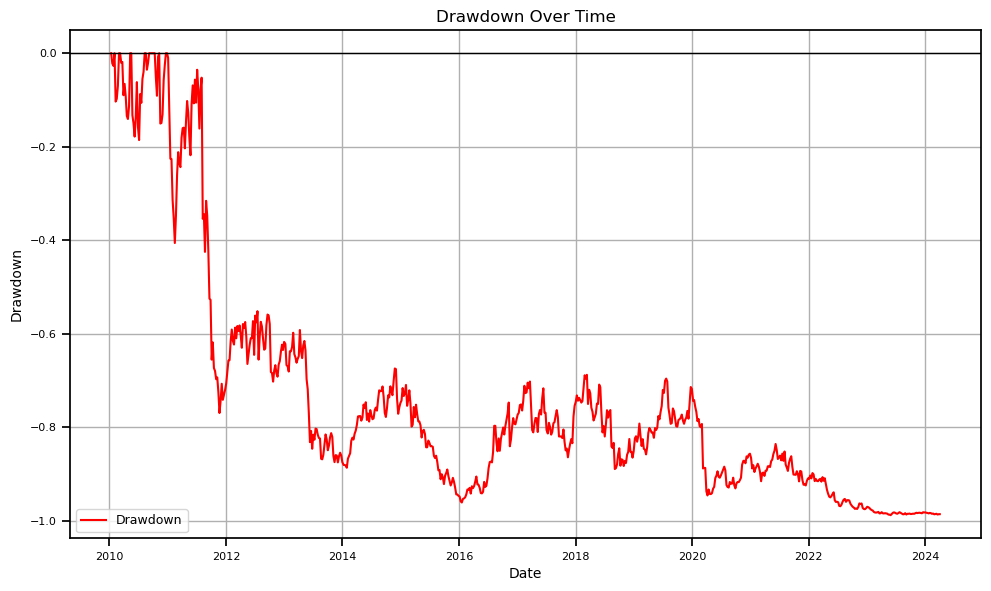

Costa Rica
Parametric VaR (alpha=5%): 12.46%
Historical VaR (alpha=5%): 10.19%
Historical Expected Shortfall: 17.80%
Maximum Drawdown: -79.78%
Drawdown Period: 2020-03-24 00:00:00 to 2021-06-15 00:00:00


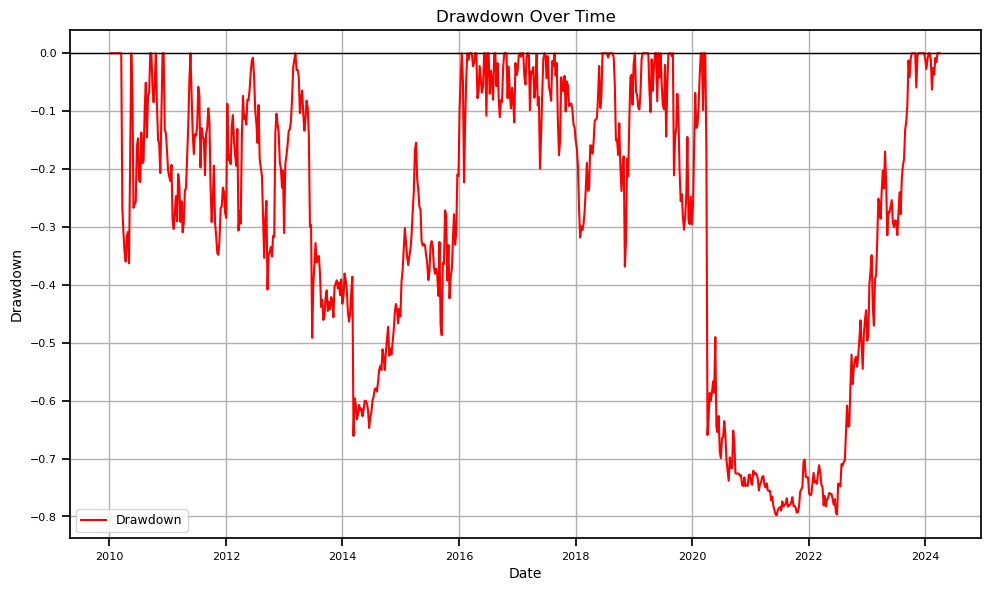

Turkey
Parametric VaR (alpha=5%): 21.78%
Historical VaR (alpha=5%): 19.16%
Historical Expected Shortfall: 32.25%
Maximum Drawdown: -103.81%
Drawdown Period: 2010-11-02 00:00:00 to 2019-02-05 00:00:00


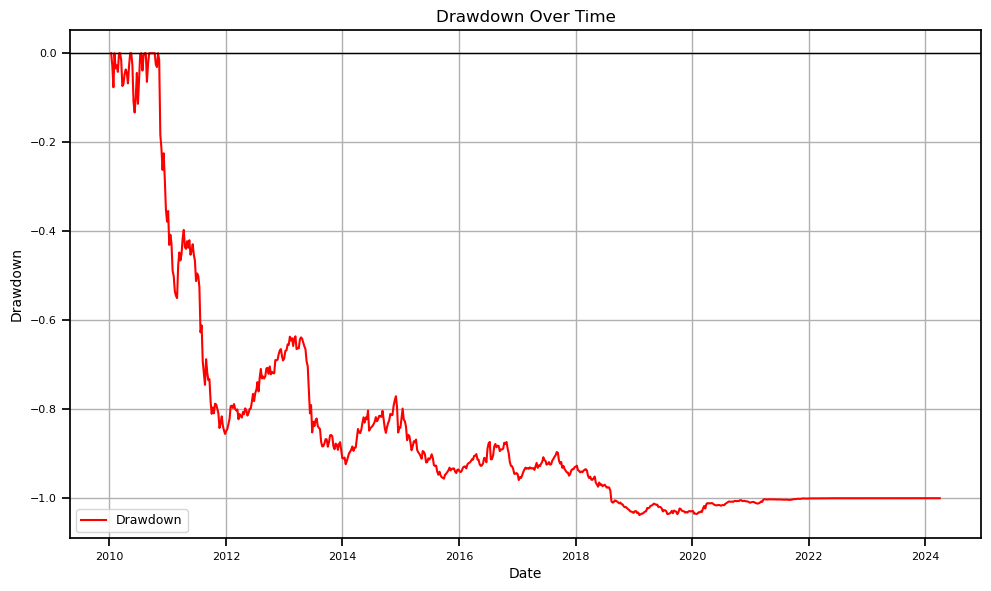

Pakistan
Parametric VaR (alpha=5%): 29.19%
Historical VaR (alpha=5%): 18.95%
Historical Expected Shortfall: 40.73%
Maximum Drawdown: -101.91%
Drawdown Period: 2020-03-24 00:00:00 to 2022-03-29 00:00:00


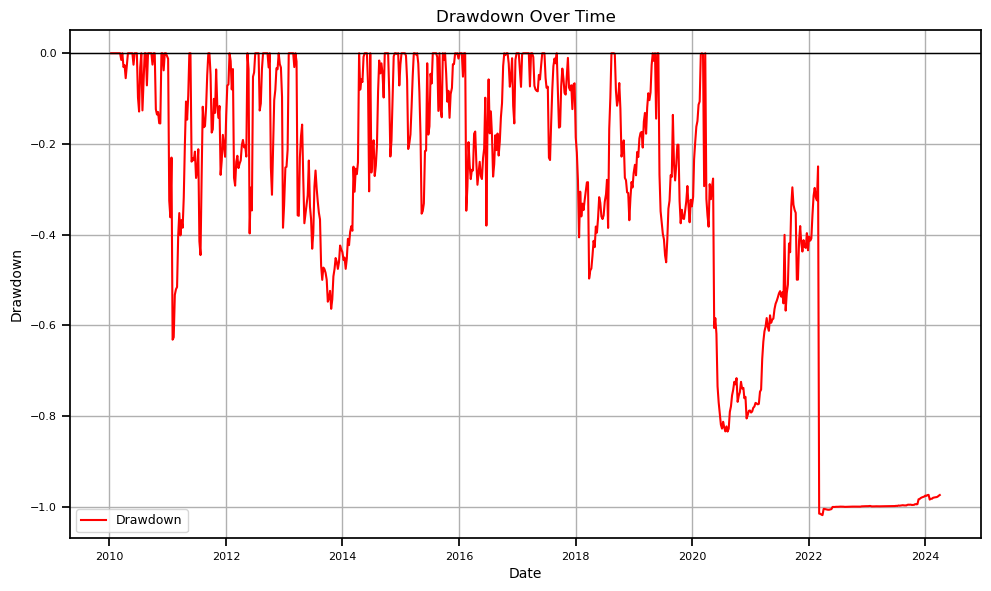

In [49]:
print("South Africa")
risk_analysis_and_drawdown_plot(carry_trade_south_africa, equity=2_000_000.0, alpha=0.05)
print("Costa Rica")
risk_analysis_and_drawdown_plot(carry_trade_costa_rica, equity=2_000_000.0, alpha=0.05)
print("Turkey")
risk_analysis_and_drawdown_plot(carry_trade_turkey, equity=2_000_000.0, alpha=0.05)
print("Pakistan")
risk_analysis_and_drawdown_plot(carry_trade_pakistan, equity=2_000_000.0, alpha=0.05)

1. Costa Rica
   - Parametric VaR ~ 12.46%, Historical VaR ~ 10.19%, ES ~ 17.80%, Max Drawdown ~ −79.78%.
   - The drawdown chart reveals significant drops but rarely as catastrophic as some deeper EM blowups.
   - A near 80% max drawdown is still severe, highlighting that occasional currency or bond repricings can cause big capital hits.
2. Pakistan
   - Parametric VaR ~ 29.19%, Historical VaR ~ 16.95%, ES ~ 40.73%, Max Drawdown ~ −181.91%.
   - The extreme max drawdown indicates multiple episodes of huge negative weekly returns—reflecting either repeated PKR devaluations or near‐crisis events.
   - This underscores the very high tail risk: while the strategy can outperform risk‐free or bond benchmarks in calm times, it faces spectacular losses when the currency collapses or capital flees.
3. Turkey
   - Parametric VaR ~ 21.70%, Historical VaR ~ 19.16%, ES ~ 32.25%, Max Drawdown ~ −103.81%.
   - The strategy endures an over −100% drawdown, indicating that leveraged weekly trades can wipe out initial equity more than once.
   - The drawdown curve plunges early (around 2010–2011) and never recovers, highlighting the Lira’s long‐term decline against GBP and the heavy cost of repeated crises.
4. South Africa
   - Parametric VaR ~ 17.37%, Historical VaR ~ 17.66%, ES ~ 23.73%, Max Drawdown ~ −90.84%.
   - Significant drawdowns underscore ZAR’s sensitivity to global commodity cycles and risk sentiment.
   - While not as extreme as Pakistan’s meltdown, a near −91% max drawdown is still critical, reflecting episodes of abrupt currency declines or bond yield spikes.

#### Cross‐Benchmark & Risk Insights
##### Benchmark Comparisons:
- SP500 is consistently the strongest performer, especially in the post‐2009 bull market, overshadowing all carry trades except for sporadic PK surges.
- TBill is the safe, slow growth baseline. Some carry trades exceed TBill comfortably; others (like Turkey) fail to outdo even the risk‐free rate.
- BND (broad bond) grows steadily, generally beating losing carry trades but lagging behind strong equity or high‐performing EM trades.
##### Correlation:
- The heatmaps show the carry PnL is weakly correlated with these standard US benchmarks, confirming that local EM factors dominate.
- Low correlation can be a diversification advantage but also means no easy hedge using typical US instruments.
##### Drawdown Observations:
- Each currency’s max drawdown is enormous—ranging from ~−80% to over −180% for Pakistan.
- This reveals the leveraged nature of weekly re‐entries plus the vulnerability of EM currencies to crisis events.
##### VaR & ES:
- Parametric VaR vs. Historical VaR can differ if the return distribution is highly skewed or has fat tails.
- Pakistan and Turkey show the largest VaR/ES, reflecting the greatest tail risk.
- Costa Rica has a relatively lower VaR/ES, aligning with more stable performance among these four.

### Rolling 6‐Month Sharpe & Rolling Correlation

In [50]:
# Computes rolling Sharpe ratio given a returns series and window (in weeks)
def compute_rolling_sharpe(returns, window=26):
    roll_mean = returns.rolling(window=window).mean()
    roll_std = returns.rolling(window=window).std()
    roll_sharpe = (roll_mean / roll_std) * np.sqrt(52)
    return roll_sharpe

# Computes rolling correlation between two returns series using a specified window (in weeks)
def compute_rolling_correlation(strategy_ret, benchmark_ret, window=26):
    return strategy_ret.rolling(window=window).corr(benchmark_ret)

# Plots rolling 6-month Sharpe and rolling correlation with benchmark for a given strategy
def plot_rolling_metrics(strategy_ret, benchmark_ret, window=26, title=""):
    roll_sharpe = compute_rolling_sharpe(strategy_ret, window)
    roll_corr = compute_rolling_correlation(strategy_ret, benchmark_ret, window)
    fig, axes = plt.subplots(2, 1, figsize=(12,8), sharex=True)
    axes[0].plot(roll_sharpe.index, roll_sharpe, label="Rolling Sharpe", color='blue')
    axes[0].set_title(f"{title} - Rolling 6-Month Sharpe Ratio")
    axes[0].set_ylabel("Sharpe Ratio")
    axes[0].grid(True)
    axes[0].legend()
    axes[1].plot(roll_corr.index, roll_corr, label="Rolling Correlation", color='green')
    axes[1].set_title(f"{title} - Rolling 6-Month Correlation with Benchmark")
    axes[1].set_ylabel("Correlation")
    axes[1].set_xlabel("Date")
    axes[1].grid(True)
    axes[1].legend()
    plt.tight_layout()
    plt.show()

# Computes weekly returns from a carry trade strategy's pnl (divided by equity) and returns the series
def compute_strategy_weekly_returns(strategy_df, equity=2_000_000.0):
    df = strategy_df.copy()
    df['exit_date'] = pd.to_datetime(df['exit_date'])
    pnl_weekly = df.groupby('exit_date')['net_pnl_usd'].sum().sort_index()
    weekly_returns = pnl_weekly / equity
    weekly_returns = weekly_returns.resample('W-FRI').last().fillna(0)
    return weekly_returns

# Compares rolling metrics for multiple carry trade strategies against a benchmark returns series
def compare_rolling_metrics_all(strategies_dict, benchmark_ret, equity=2_000_000.0, window=26):
    results = {}
    for currency, strat_df in strategies_dict.items():
        strat_ret = compute_strategy_weekly_returns(strat_df, equity)
        plot_rolling_metrics(strat_ret, benchmark_ret, window, title=currency)
        results[currency] = strat_ret
    return results

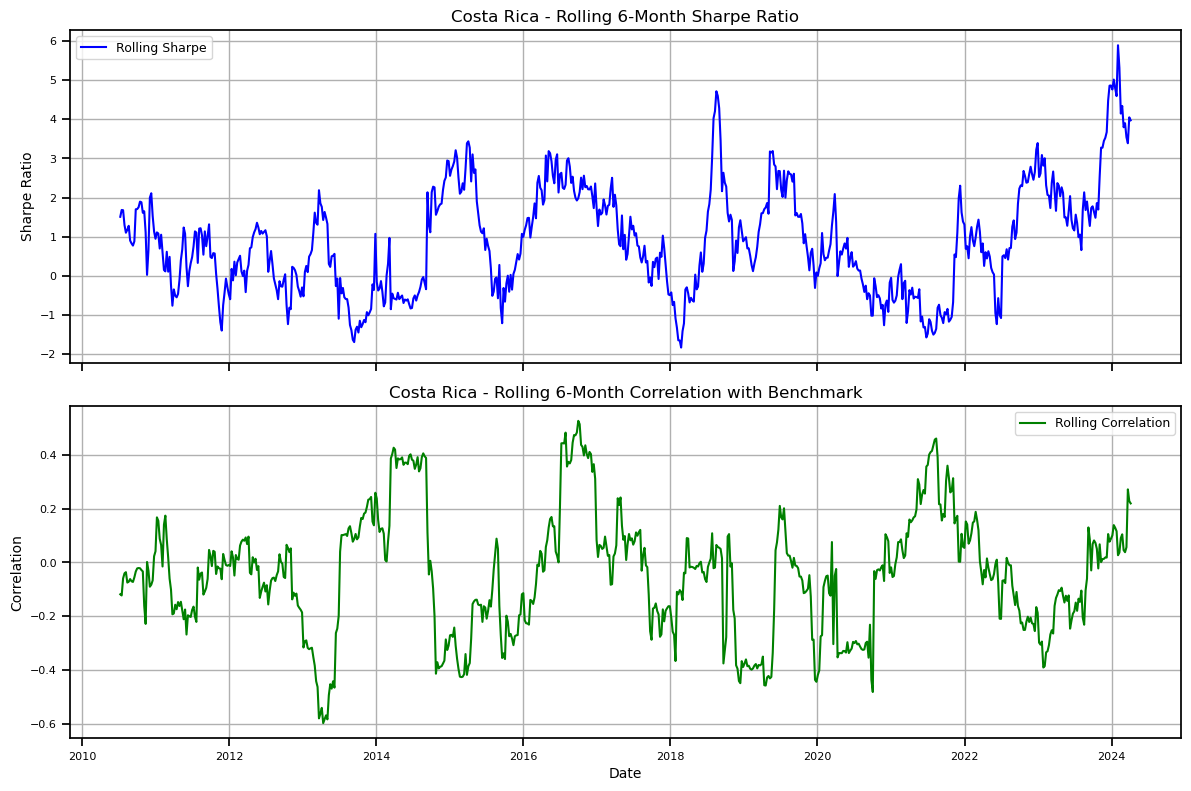

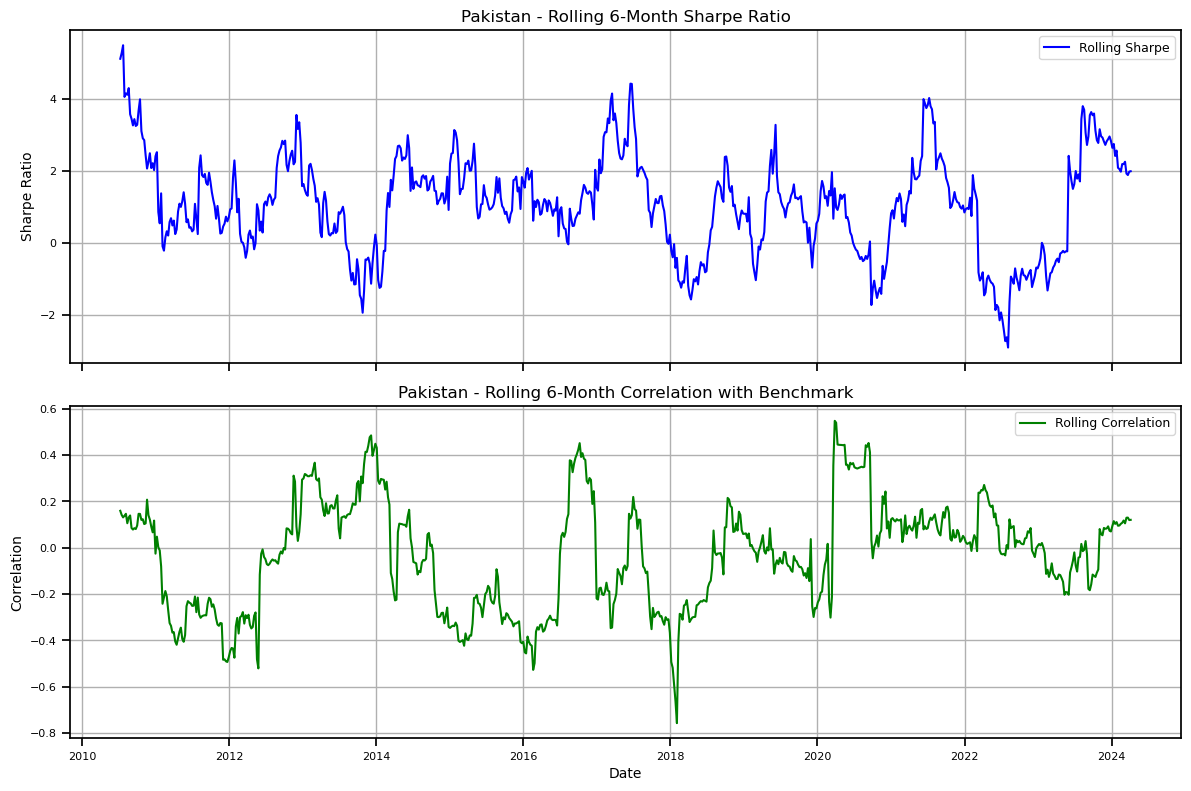

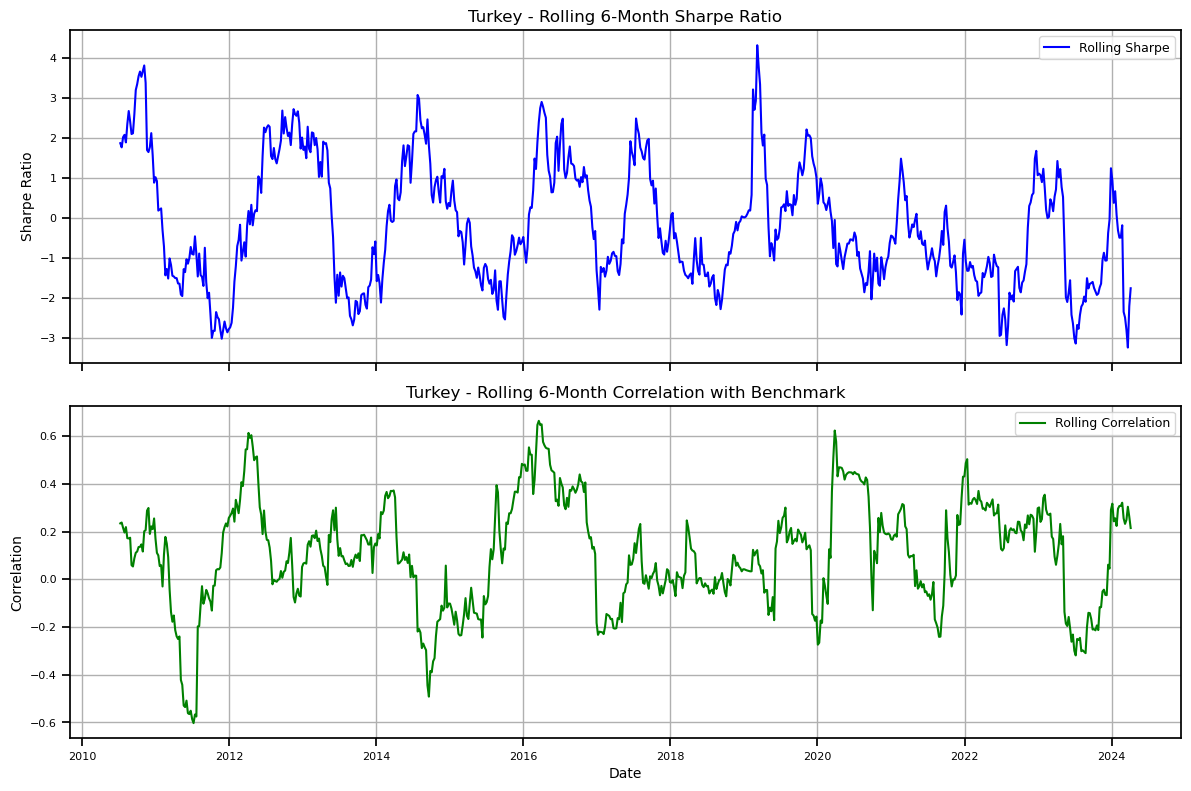

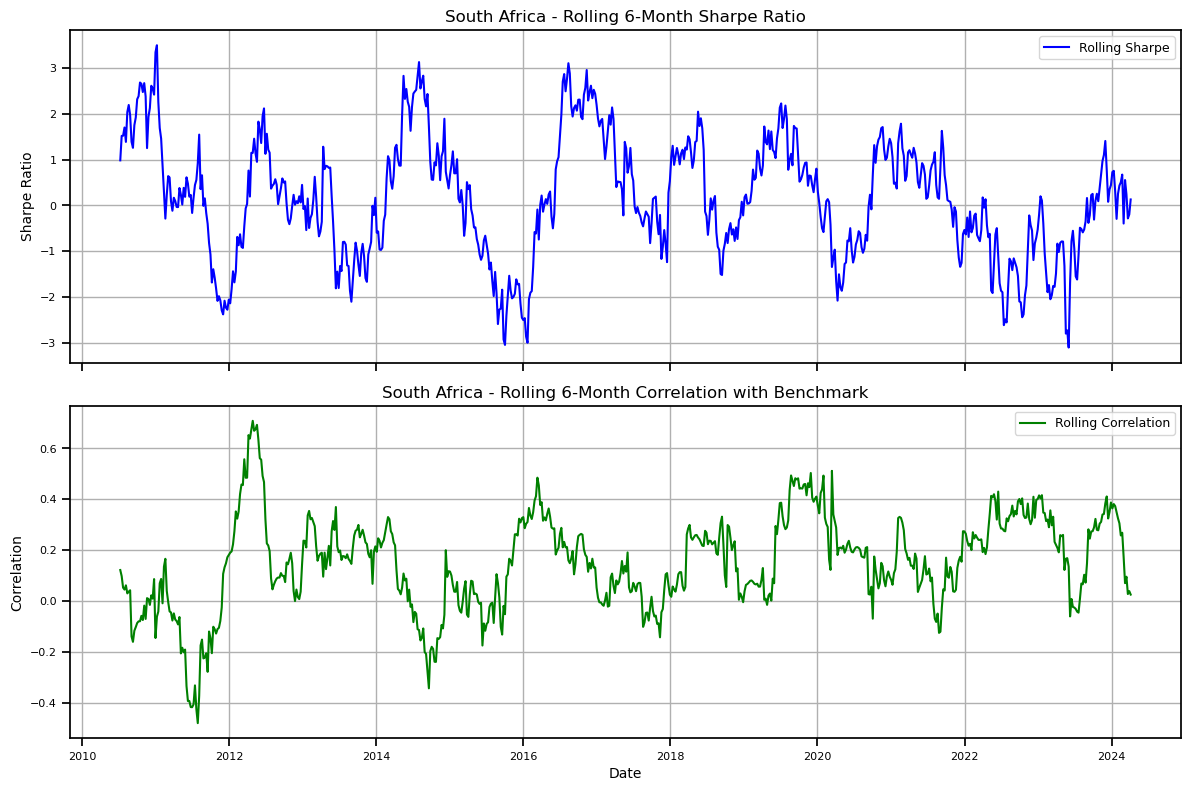

In [51]:
sp500_ret = daily_to_weekly_returns(sp500, column_name='SPY') 
strategies = {
    'Costa Rica': carry_trade_costa_rica,
    'Pakistan': carry_trade_pakistan,
    'Turkey': carry_trade_turkey,
    'South Africa': carry_trade_south_africa
}
rolling_results = compare_rolling_metrics_all(strategies, sp500_ret, equity=2_000_000.0, window=26)

1. Costa Rica
   - Rolling Sharpe: Fluctuates from negative to as high as 5–6, implying that over some 6‐month windows the strategy delivered strong risk‐adjusted returns, while in other periods it dipped below zero. This variability reflects periodic FX or bond market repricing events.
   - Rolling Correlation: Often between −0.2 and +0.4 with the chosen benchmark (e.g., S&P 500). Suggests a mild or even inverse relationship in certain risk‐off phases, reinforcing that Costa Rica’s carry returns hinge more on local yield and currency stability than broad equity moves.
2. Pakistan
   - Rolling Sharpe: Repeated swings between positive (2–3 range) and negative territory. Shows that in stable PKR environments with high carry, returns can be stellar, but crises or abrupt devaluations can annihilate short‐term Sharpe.
   - Rolling Correlation: Drifts from near 0 to about +0.4, indicating some moderate co‐movement with the global benchmark at times, likely during “risk‐on” phases, but not a consistent pattern. This highlights the currency’s idiosyncratic drivers (political or IMF‐related) overshadowing typical market correlations.
3. Turkey
   - Rolling Sharpe: Frequently negative, occasionally spiking positive (near +2 or +3). This underscores the Lira’s periodic short squeezes or risk‐on mini‐rallies, but overall negative performance drags down average Sharpe.
   - Rolling Correlation: Shifts from about −0.2 up to +0.6, reflecting that in risk‐on phases capital briefly supports TRY, but in risk‐off or local policy missteps, the currency plunges independently. The correlation’s instability mirrors Turkey’s boom‐bust cycles.
4. South Africa
   - Rolling Sharpe: Oscillates between −2 and +4, revealing that ZAR carry can be very profitable in commodity‐friendly or stable global environments, yet experiences deep negative runs when volatility spikes or local fundamentals deteriorate.
   - Rolling Correlation: Typically from 0 to +0.5, sometimes dipping negative. Aligns with the notion that ZAR can track equity risk appetite but still experiences idiosyncratic shocks (e.g., power crises, credit downgrades).

## Trading Strategy Idea!
- Trading Strategy1 : Each week -  Equal Weighted
- Trading Strategy2 : Each week - Max Spread 
- Cumulative PnL Comparison: Four Single‐Currency Strategies + Max Spread + Equal Weighted

In [52]:
def simulate_fx_carry_max_spread(
    currencies_df,
    iudsoia_df,
    funding_5y_swap_rate_df,
    swap_yield_curves,
    discount_factors_dict,
    start_date,
    end_date,
    spread_bps_threshold=50.0,
    holiday_calendar='USFederal',
    equity_usd=2_000_000.0,
    borrowed_usd=8_000_000.0
):
    """
    Simulates the FX carry strategy but each week picks the single region with the maximum swap spread
    (lending_5y_rate - funding_5y_rate). If the max spread is below 'spread_bps_threshold' basis points,
    no position is taken for that week.
    """

    iudsoia_df = prepare_df(iudsoia_df, start_date, end_date)
    funding_5y_swap_rate_df = prepare_df(funding_5y_swap_rate_df, start_date, end_date)
    currencies_df = prepare_df(currencies_df, start_date, end_date)
    for region in discount_factors_dict:
        discount_factors_dict[region] = prepare_df(discount_factors_dict[region], start_date, end_date)
    for region in swap_yield_curves:
        swap_yield_curves[region] = prepare_df(swap_yield_curves[region], start_date, end_date)
    holiday_set = build_us_federal_holiday_set(start_date, end_date)
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    date_range = date_range[date_range <= end_date]

    results = []
    trade_id = 0

    for current_date in date_range:
        # Enter only on Wednesdays (or adjusted forward if holiday)
        if current_date.weekday() != 2:
            continue
        entry_date = current_date
        if not is_business_day(entry_date, holiday_set):
            entry_date = adjust_to_business_day(entry_date, 'forward', holiday_set)
        if entry_date > end_date:
            break

        # Find nearest OIS and 5Y funding rate
        if entry_date not in iudsoia_df.index:
            idx_entry = find_nearest_index_date(iudsoia_df.index, entry_date)
        else:
            idx_entry = entry_date

        if entry_date not in funding_5y_swap_rate_df.index:
            idx_fund = find_nearest_index_date(funding_5y_swap_rate_df.index, entry_date)
        else:
            idx_fund = entry_date

        if (idx_entry not in iudsoia_df.index) or (idx_fund not in funding_5y_swap_rate_df.index):
            continue

        ois_rate = iudsoia_df.loc[idx_entry, 'IUDSOIA'] / 100.0
        funding_5y_rate = funding_5y_swap_rate_df.loc[idx_fund, '5Y'] / 100.0
        borrowing_rate = ois_rate + 0.005

        # Determine exit date
        exit_date = entry_date + pd.Timedelta(days=6)
        if exit_date > end_date:
            exit_date = end_date
        if not is_business_day(exit_date, holiday_set):
            exit_date = adjust_to_business_day(exit_date, 'backward', holiday_set)
        if exit_date <= entry_date:
            continue

        if exit_date not in currencies_df.index:
            fx_exit_idx = find_nearest_index_date(currencies_df.index, exit_date)
        else:
            fx_exit_idx = exit_date

        days_held = day_count(entry_date, exit_date)
        if days_held <= 0:
            continue

        # We will gather all potential trades (region, spread, etc.) then pick the max spread
        potential_trades = []
        for region, curve_df in swap_yield_curves.items():
            if entry_date not in curve_df.index:
                nearest_curve_entry = find_nearest_index_date(curve_df.index, entry_date)
            else:
                nearest_curve_entry = entry_date
            if exit_date not in curve_df.index:
                nearest_curve_exit = find_nearest_index_date(curve_df.index, exit_date)
            else:
                nearest_curve_exit = exit_date

            if (nearest_curve_entry not in curve_df.index) or (nearest_curve_exit not in curve_df.index):
                continue

            s5_lending_entry = curve_df.loc[nearest_curve_entry, 5.0]
            spread_decimal = s5_lending_entry - funding_5y_rate
            potential_trades.append((region, s5_lending_entry, spread_decimal, nearest_curve_entry, nearest_curve_exit))

        if not potential_trades:
            continue

        # Pick the region with the maximum spread
        region_max, s5_lending_entry_max, spread_max, c_entry, c_exit = max(potential_trades, key=lambda x: x[2])
        # If spread is below threshold, skip
        if (spread_max * 10000) < spread_bps_threshold:
            continue

        # Now do the borrowing in GBP
        if entry_date not in currencies_df.index:
            fx_entry_idx = find_nearest_index_date(currencies_df.index, entry_date)
        else:
            fx_entry_idx = entry_date
        fx_gbp_entry = currencies_df.loc[fx_entry_idx, 'USDGBP']
        fx_gbp_exit  = currencies_df.loc[fx_exit_idx, 'USDGBP']
        borrowed_gbp = borrowed_usd * fx_gbp_entry
        borrow_interest_gbp = borrowed_gbp * borrowing_rate * (days_held / 365.0)
        repay_gbp = borrowed_gbp + borrow_interest_gbp
        repay_usd = repay_gbp / fx_gbp_exit

        # Lending currency logic
        if region_max == 'Rep Turkey':
            fx_col = 'USDTRY'
        elif region_max == 'Islamic Rep Pakistan':
            fx_col = 'USDPKR'
        elif region_max == 'Rep Costa Rica':
            fx_col = 'USDCRC'
        elif region_max == 'Rep South Africa':
            fx_col = 'USDZAR'
        else:
            continue

        fx_loc_entry = currencies_df.loc[fx_entry_idx, fx_col]
        fx_loc_exit  = currencies_df.loc[fx_exit_idx, fx_col]
        invest_local = (equity_usd + borrowed_usd) * fx_loc_entry

        # Bond pricing at entry
        df_factors_entry = discount_factors_dict[region_max].loc[c_entry].dropna()
        if df_factors_entry.empty:
            continue
        bond_price_entry = price_bond_after_days(
            coupon_annual=s5_lending_entry_max,
            df_series=df_factors_entry,
            days_elapsed=0.0,
            freq=4,
            maturity=5.0,
            face=1.0
        )
        num_bonds = invest_local / bond_price_entry

        # Bond pricing at exit
        df_factors_exit = discount_factors_dict[region_max].loc[c_exit].dropna()
        if df_factors_exit.empty:
            continue
        bond_price_exit = price_bond_after_days(
            coupon_annual=s5_lending_entry_max,
            df_series=df_factors_exit,
            days_elapsed=days_held,
            freq=4,
            maturity=5.0,
            face=1.0
        )

        # Accrued interest on the coupon
        accrued_interest = (s5_lending_entry_max / 4.0) * (days_held * 4 / 365.0)

        final_local_proceeds = num_bonds * (bond_price_exit + accrued_interest)
        final_usd_proceeds = final_local_proceeds / fx_loc_exit
        lend_leg_pnl_usd = final_usd_proceeds - (equity_usd + borrowed_usd)
        borrow_leg_cost_usd = repay_usd - borrowed_usd
        net_pnl_usd = lend_leg_pnl_usd - borrow_leg_cost_usd

        trade_id += 1
        results.append({
            'trade_id': trade_id,
            'region': region_max,
            'entry_date': entry_date,
            'exit_date': exit_date,
            'days_held': days_held,
            'funding_5y_rate_entry': funding_5y_rate,
            'lending_5y_rate_entry': s5_lending_entry_max,
            'ois_borrow_rate_entry': ois_rate,
            'funding_rate': borrowing_rate,
            'spread_decimal': spread_max,
            'fx_gbp_entry': fx_gbp_entry,
            'fx_gbp_exit': fx_gbp_exit,
            'fx_lending_entry': fx_loc_entry,
            'fx_lending_exit': fx_loc_exit,
            'borrow_gbp_entry': borrowed_gbp,
            'interest_gbp': borrow_interest_gbp,
            'repay_gbp_exit': repay_gbp,
            'repay_usd_exit': repay_usd,
            'invest_local_entry': invest_local,
            'bond_price_entry': bond_price_entry,
            'bond_price_exit': bond_price_exit,
            'accrued_interest': accrued_interest,
            'num_bonds': num_bonds,
            'final_local_proceeds': final_local_proceeds,
            'final_usd_proceeds': final_usd_proceeds,
            'lend_leg_pnl_usd': lend_leg_pnl_usd,
            'borrow_leg_cost_usd': borrow_leg_cost_usd,
            'net_pnl_usd': net_pnl_usd
        })

    return pd.DataFrame(results)


In [53]:
max_spread_carry_trade_results = simulate_fx_carry_max_spread(
    currencies_df,
    iudsoia,
    funding_5y_swap_rate,
    swap_yield_curves,
    discount_factors_dict,
    start_date=pd.to_datetime("2000-01-04"),
    end_date=pd.to_datetime("2024-04-02"),
    spread_bps_threshold=50.0,
    holiday_calendar='USFederal',
    equity_usd=2_000_000.0,
    borrowed_usd=8_000_000.0
)
max_spread_carry_trade_results

,trade_id,region,entry_date,exit_date,days_held,funding_5y_rate_entry,lending_5y_rate_entry,ois_borrow_rate_entry,funding_rate,spread_decimal,...,invest_local_entry,bond_price_entry,bond_price_exit,accrued_interest,num_bonds,final_local_proceeds,final_usd_proceeds,lend_leg_pnl_usd,borrow_leg_cost_usd,net_pnl_usd
0,1,Islamic Rep Pakistan,2010-01-06,2010-01-12,6,0.030289,0.136000,0.004534,0.009534,0.105711,...,8.450917e+08,1.0,1.017046,0.002236,8.450917e+08,8.613865e+08,1.018025e+07,180252.116248,81455.223568,98796.892680
1,2,Islamic Rep Pakistan,2010-01-13,2010-01-19,6,0.029577,0.131722,0.004530,0.009530,0.102145,...,8.484911e+08,1.0,1.003225,0.002165,8.484911e+08,8.530645e+08,1.007452e+07,74519.199435,38105.855288,36413.344147
2,3,Islamic Rep Pakistan,2010-01-20,2010-01-26,6,0.030362,0.131167,0.004542,0.009542,0.100805,...,8.464357e+08,1.0,1.004859,0.002156,8.464357e+08,8.523739e+08,1.009846e+07,98456.545798,-71827.355168,170283.900966
3,4,Islamic Rep Pakistan,2010-01-27,2010-02-02,6,0.029018,0.130467,0.004566,0.009566,0.101449,...,8.435623e+08,1.0,1.002259,0.002145,8.435623e+08,8.472772e+08,9.970388e+06,-29611.958628,-113376.539615,83764.580987
4,5,Islamic Rep Pakistan,2010-02-03,2010-02-09,6,0.028923,0.130467,0.004602,0.009602,0.101544,...,8.500329e+08,1.0,1.002259,0.002145,8.500329e+08,8.537763e+08,1.005646e+07,56460.265530,-133419.289037,189879.554567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,739,Islamic Rep Pakistan,2024-02-28,2024-03-05,6,0.040702,0.439063,0.051882,0.056882,0.398361,...,2.772097e+09,1.0,1.007616,0.007217,2.772097e+09,2.813215e+09,1.006483e+07,64827.155600,21343.721315,43483.434285
739,740,Islamic Rep Pakistan,2024-03-06,2024-03-12,6,0.039370,0.438154,0.051883,0.056883,0.398784,...,2.794781e+09,1.0,1.003171,0.007203,2.794781e+09,2.823773e+09,1.010986e+07,109861.713036,77349.042747,32512.670288
740,741,Islamic Rep Pakistan,2024-03-13,2024-03-19,6,0.039177,0.440293,0.051889,0.056889,0.401116,...,2.793978e+09,1.0,1.000170,0.007238,2.793978e+09,2.814675e+09,1.003374e+07,33742.562843,-48517.355853,82259.918696
741,742,Islamic Rep Pakistan,2024-03-20,2024-03-26,6,0.039390,0.415109,0.051892,0.056892,0.375719,...,2.787500e+09,1.0,1.005881,0.006824,2.787500e+09,2.822915e+09,1.015900e+07,159000.075378,-38108.002212,197108.077590


In [54]:
region_counts = max_spread_carry_trade_results['region'].value_counts()
print(region_counts)

region
Islamic Rep Pakistan    664
Rep Costa Rica           63
Rep Turkey               16
Name: count, dtype: int64


- Pakistan chosen 664 times, Costa Rica 63, Turkey 16, South Africa 0.
- The PKR swap rate minus GBP 5Y rate evidently dominates the spread for most of the sample, overshadowing the others.
- Reflects local interest rates in Pakistan remain significantly higher than the rest, so the strategy mostly invests there, capturing large carry at the cost of currency blowup risk

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Computes weekly PnL (USD) for a carry trade simulation DataFrame
def get_weekly_pnl(sim_df):
    df = sim_df.copy()
    df['exit_date'] = pd.to_datetime(df['exit_date'])
    weekly_pnl = df.groupby('exit_date')['net_pnl_usd'].sum().sort_index()
    weekly_pnl = weekly_pnl.resample('W-FRI').sum().fillna(0)
    return weekly_pnl

# Computes equal-weighted portfolio's weekly PnL by averaging the 4 single-currency weekly PnLs
def compute_equal_weighted_portfolio(pnl_dict):
    df_combined = pd.concat(pnl_dict.values(), axis=1).fillna(0)
    df_combined.columns = pnl_dict.keys()
    eq_pnl = df_combined.mean(axis=1)
    return eq_pnl

# Plots cumulative PnL for multiple series and prints mean, std, Sharpe
def compare_and_plot_pnls(pnl_series_dict, equity=2_000_000.0):
    plt.figure(figsize=(12,8))
    stats_list = []
    for label, pnl_s in pnl_series_dict.items():
        cum_pnl = pnl_s.cumsum()
        plt.plot(cum_pnl.index, cum_pnl, label=label)
        weekly_ret = pnl_s / equity
        mean_ret = weekly_ret.mean()
        std_ret = weekly_ret.std()
        sharpe = (mean_ret / std_ret) * np.sqrt(52) if std_ret!=0 else np.nan
        stats_list.append([label, mean_ret*52, std_ret*np.sqrt(52), sharpe])
    plt.title("Cumulative PnL Comparison")
    plt.xlabel("Date")
    plt.ylabel("Cumulative PnL (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    stats_df = pd.DataFrame(stats_list, columns=["Portfolio","Annualized Mean","Annualized Vol","Sharpe"])
    display(stats_df)

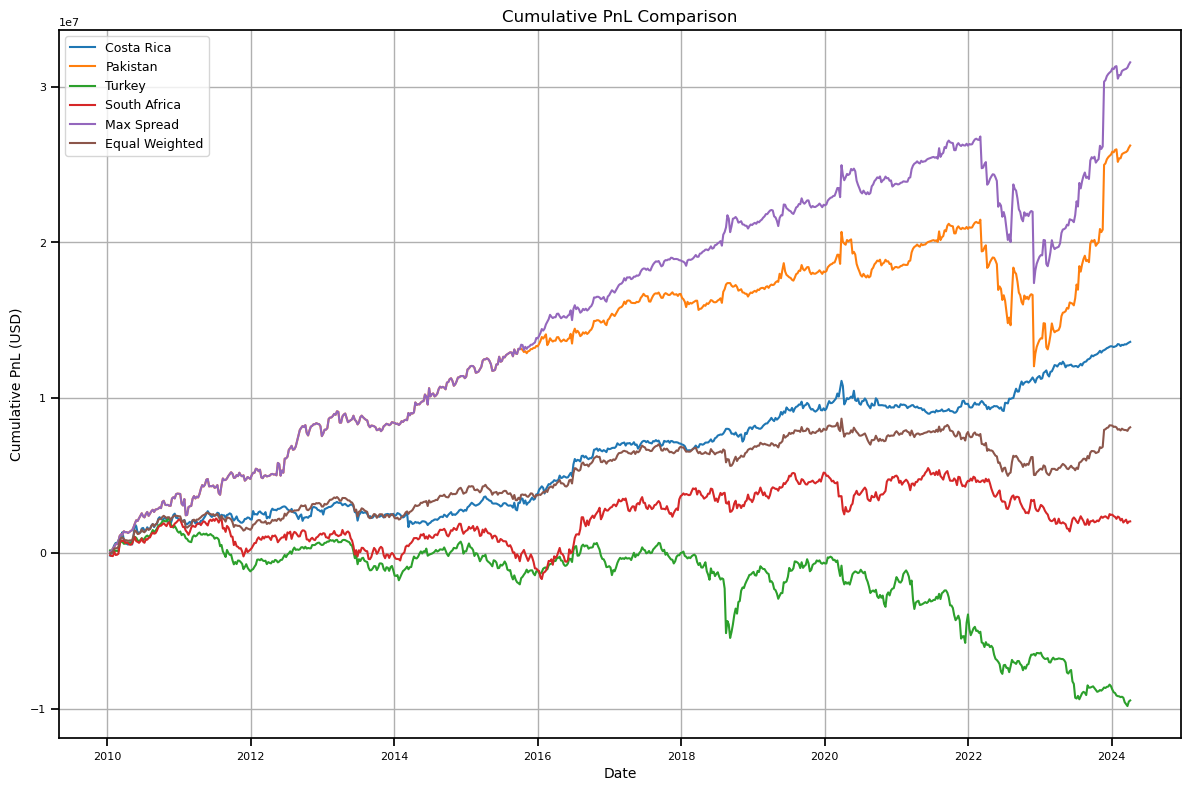

,Portfolio,Annualized Mean,Annualized Vol,Sharpe
0,Costa Rica,0.475918,0.586218,0.811845
1,Pakistan,0.918055,1.357118,0.676474
2,Turkey,-0.331556,0.926859,-0.357720
3,South Africa,0.071679,0.767624,0.093378
4,Max Spread,1.105421,1.356599,0.814848
5,Equal Weighted,0.283524,0.583373,0.486008


In [56]:
single_costa = get_weekly_pnl(carry_trade_costa_rica)
single_pak   = get_weekly_pnl(carry_trade_pakistan)
single_turk  = get_weekly_pnl(carry_trade_turkey)
single_sa    = get_weekly_pnl(carry_trade_south_africa)
single_max   = get_weekly_pnl(max_spread_carry_trade_results)
eq_portfolio = compute_equal_weighted_portfolio({
    'Costa Rica': single_costa,
    'Pakistan': single_pak,
    'Turkey': single_turk,
    'South Africa': single_sa
})
final_dict = {
    'Costa Rica': single_costa,
    'Pakistan': single_pak,
    'Turkey': single_turk,
    'South Africa': single_sa,
    'Max Spread': single_max,
    'Equal Weighted': eq_portfolio
}
compare_and_plot_pnls(final_dict, equity=2_000_000.0)


#### PnL Comparision
- Costa Rica - Consistently higher trajectory than Turkey or South Africa, somewhat behind Pakistan’s steep climbs. The stable yield advantage and moderate FX volatility help produce a fairly steady upward line.
- Pakistan: Large upward spikes. Periodically leads the pack but also sees big retracements. Over the long term, it can reach a very high level, reflecting the massive yield in PKR. However, short, sharp crashes can significantly reduce returns if timed poorly.
- Turkey: Negative slope overall, well below the others. The repeated Lira crises overshadow the high nominal rates. The final line remains in loss territory, highlighting how devastating currency depreciation can be to a carry strategy.
- South Africa: Modest upward drift, less explosive than Pakistan, more stable than Turkey. Ends above zero but below Costa Rica. The ZAR’s commodity ties and risk‐off sensitivity limit net returns.
- Max Spread: Heavily dominated by Pakistan (664 weeks) and rarely invests in Costa Rica (63) or Turkey (16). This indicates Pakistan usually offers the largest yield spread above GBP. The final PnL line often outperforms because it’s effectively “Pakistan carry” most of the time. It also can suffer severe drawdowns in PKR crises, but over this sample, the net effect is high growth.
- Equal Weighted: A blended line that invests in all four currencies each week with equal capital. Produces a smoother path than Pakistan alone but typically underperforms the best single performer (especially if Pakistan soared). Diversification helps mitigate Turkey’s big losses but also dilutes Pakistan’s huge spikes.

#### Performance Table 
- Pakistan: Highest annualized mean but also very high volatility. The Sharpe is moderate, reflecting big swings.
- Costa Rica: Lower absolute return but a more favorable Sharpe due to lower volatility.
- Turkey: Negative returns, high vol, negative Sharpe.
- South Africa: Modest positive returns, moderate Sharpe.
- Max Spread: Typically outperforms in absolute PnL because it invests in Pakistan most weeks. Risk can be extreme.
- Equal Weighted: Gains diversification benefits, yielding moderate returns with lower risk than pure Pakistan.

# Conclusion

This study highlights the increasing tension between high nominal yields in emerging markets and the deep structural vulnerabilities that can abruptly overturn carry trades. Our findings demonstrate that while currencies such as Pakistan’s can deliver spectacular returns under favorable conditions—reflecting the enormous interest‐rate differentials—sudden episodes of political instability, fiscal crises, or policy missteps can wipe out accumulated gains overnight. Conversely, more stable environments like Costa Rica highlight the potential for a balanced risk‐return trade‐off, yet remain susceptible to global risk aversion, commodity shocks, or shifts in local central‐bank policy. Through this lens, the “max spread” rotation strategy, which persistently chases the highest yield, reveals both the allure of outsized returns and the perils of concentration in the riskiest currency at precisely the wrong time.

Beyond individual currency narratives, the analysis of rolling Sharpe ratios, drawdowns, and factor regressions reveals that conventional equity style factors and standard benchmarks (e.g., S&P 500, BND, T‐Bill) offer only limited explanatory power. Instead, local monetary regimes, external debt structures, and macro events dominate the performance of EM carry. Real‐world flashpoints—such as central‐bank independence controversies in Turkey, IMF negotiations in Pakistan, or Brexit’s effect on GBP funding costs—impose abrupt dislocations on these trades. Consequently, global carry investors must remain attuned not only to traditional risk metrics but also to the geopolitical and economic undercurrents that shape capital flows and currency market sentiment.

The substantial tail risks and drawdowns encountered in our simulations serve as a cautionary reminder that EM carry is more than a simple yield grab; it is a complex, leveraged bet on political stability, inflation management, and international capital mobility. Our results confirm that diversification—be it through an equal‐weighted portfolio of multiple EM currencies or partial hedges against severe devaluations—can mitigate, though not eliminate, the potential for catastrophic losses. Ultimately, those seeking to harness EM carry’s high returns must combine a thorough understanding of local fundamentals with robust risk management frameworks, including stress tests, tail hedges, and real‐time monitoring of liquidity conditions.

Looking forward, as global monetary cycles evolve and new geopolitical tensions arise, the interplay between yield spreads and currency stability will remain a pivotal challenge for practitioners. While EM carry can complement a broader portfolio through its low correlation to developed‐market assets, its reliance on fragile political and economic equilibria exposes investors to abrupt regime shifts and sentiment reversals. Thus, success in this domain hinges on proactive, adaptive strategies—ready to exit or rotate at the first sign of structural break—while maintaining sufficient capital reserves and hedges to survive unexpected turmoil.

Note: Use of AI (ChatGPT) to clean up the code, expand, clean, and beautify descriptive analysis writeup